# Diabetes Indicator
With theis project i hope to try and use whatever ive learnt in my previos code the water quality predictor to indicate wheter a patient has diabetes or not.
My hope is to get a higher accuracy of over 80% but lets see.

## Some Talk on Diabetes

> Diabetes is among the most prevalent chronic diseases in the United States, impacting millions of Americans each year and exerting a significant financial burden on the economy. Diabetes is a serious chronic disease in which individuals lose the ability to effectively regulate levels of glucose in the blood, and can lead to reduced quality of life and life expectancy. After different foods are broken down into sugars during digestion, the sugars are then released into the bloodstream. This signals the pancreas to release insulin. Insulin helps enable cells within the body to use those sugars in the bloodstream for energy. Diabetes is generally characterized by either the body not making enough insulin or being unable to use the insulin that is made as effectively as needed.

> Complications like heart disease, vision loss, lower-limb amputation, and kidney disease are associated with chronically high levels of sugar remaining in the bloodstream for those with diabetes. While there is no cure for diabetes, strategies like losing weight, eating healthily, being active, and receiving medical treatments can mitigate the harms of this disease in many patients. Early diagnosis can lead to lifestyle changes and more effective treatment, making predictive models for diabetes risk important tools for public and public health officials.

> The scale of this problem is also important to recognize. The Centers for Disease Control and Prevention has indicated that as of 2018, 34.2 million Americans have diabetes and 88 million have prediabetes. Furthermore, the CDC estimates that 1 in 5 diabetics, and roughly 8 in 10 prediabetics are unaware of their risk. While there are different types of diabetes, type II diabetes is the most common form and its prevalence varies by age, education, income, location, race, and other social determinants of health. Much of the burden of the disease falls on those of lower socioeconomic status as well. Diabetes also places a massive burden on the economy, with diagnosed diabetes costs of roughly $327 billion dollars and total costs with undiagnosed diabetes and prediabetes approaching $400 billion dollars annually.

In [1]:
# installing needed libraries

try:
    import missingno as msno
except:
    %pip install missingno

try:
    import plotly
except:
    %pip install plotly

try:
    import xgboost
    import lightgbm
except:
    %pip install lightgbm xgboost

try:
    import warnings
except:
    %pip install warnings

try:
    import hyperopt
except:
    %pip install hyperopt

try:
    import imblearn
except:
    %pip install imblearn

print("3rd Party Libraries are installed")

3rd Party Libraries are installed


In [2]:
# setting up all necessary libraries
# this approach is actually a copy of kaggle I just like it this way.

import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
for dirname, _, filenames in os.walk('.\kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# data exploration
import missingno as msno

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Accuracy Visualization
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, auc
from sklearn.metrics import f1_score, classification_report, recall_score
from sklearn.model_selection import cross_val_score

# Export Model
import joblib

# Model Fine-Tuning
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin
from sklearn.model_selection import GridSearchCV

# this is not needed I just don't like the warnings
import warnings
warnings.simplefilter("ignore")

# set seaborn as default style
sns.set()

.\kaggle\input\diabetes-health-indicators-dataset\diabetes_012_health_indicators_BRFSS2015.csv
.\kaggle\input\diabetes-health-indicators-dataset\diabetes_binary_5050split_health_indicators_BRFSS2015.csv
.\kaggle\input\diabetes-health-indicators-dataset\diabetes_binary_health_indicators_BRFSS2015.csv


## 1.Reading and analyzing the Data

As you will notice in my dataset I have 3 different csv files

### from the kaggle site:
File1: diabetes _ 012 _ health _ indicators _ BRFSS2015.csv is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_012 has 3 classes. 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes. There is class imbalance in this dataset. This dataset has 21 feature variables

File2: diabetes _ binary _ 5050split _ health _ indicators _ BRFSS2015.csv is a clean dataset of 70,692 survey responses to the CDC's BRFSS2015. It has an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is balanced.

File3: diabetes _ binary _ health _ indicators _ BRFSS2015.csv is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is not balanced.

> So from the above we now know that there isn't much of a significant change in the data features so the feature engineering will be the same.
> The only difference is how balanced the data is and the number of rows in the dataset

> 1 Common pattern we can see is that for a dataset to be balanced it seems we can only use very little data
> but for otherwise for an imbalanced data we have tons and tons of rows

As you have seen on top since the least amount of data is present in the 2nd file i will start on that file and later do it for the other files also

1 more thing before that I just wanted to show the layout for the web app that I am going to build.
<br>
![app-flowchart.png](./app-flowchart.png)

So based on this we need only 1 model. but im going to make 2

1. This model will find wheter a person has diabetes or not -> binary outcome
2. This model will find if he has type 1, 2 diabetes or no diabetes -> 3 outcomes | no diabetes | prediabetes | type 2

So for model 1 I can use file 2 to trained model and for model 2 I can use file 3 to trained model.

Now you maybe wondering why im creating two models when i only need one. well there are two reasons.
> Im an idiot and in and old scheme thaught i needed two models <br> and since I already did make the first model I thaught instead of wasting it I will upload this model to the api for others to use if they want it

I will start with model one because since it containes a balenced data it is more easier for me to work on it

# Model 1 (FILE 2)

In [3]:
data = pd.read_csv(".\kaggle\input\diabetes-health-indicators-dataset\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
data.shape

(70692, 22)

In [4]:
# this is just a util function that helps in changing the finaly Result to a sensible name
def replace_data_name(df):
    df = df.rename(columns = {'Diabetes_binary': 'IsDiabetic', 'Diabetes_012': 'IsDiabetic'})
    return df

data = replace_data_name(data)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IsDiabetic            70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [6]:
print(data.describe(include='all'))

         IsDiabetic        HighBP      HighChol     CholCheck           BMI  \
count  70692.000000  70692.000000  70692.000000  70692.000000  70692.000000   
mean       0.500000      0.563458      0.525703      0.975259     29.856985   
std        0.500004      0.495960      0.499342      0.155336      7.113954   
min        0.000000      0.000000      0.000000      0.000000     12.000000   
25%        0.000000      0.000000      0.000000      1.000000     25.000000   
50%        0.500000      1.000000      1.000000      1.000000     29.000000   
75%        1.000000      1.000000      1.000000      1.000000     33.000000   
max        1.000000      1.000000      1.000000      1.000000     98.000000   

             Smoker        Stroke  HeartDiseaseorAttack  PhysActivity  \
count  70692.000000  70692.000000          70692.000000  70692.000000   
mean       0.475273      0.062171              0.147810      0.703036   
std        0.499392      0.241468              0.354914      0.456924

In [7]:
data.head()

,IsDiabetic,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


## 2. Looking For Missing Data

IsDiabetic              0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


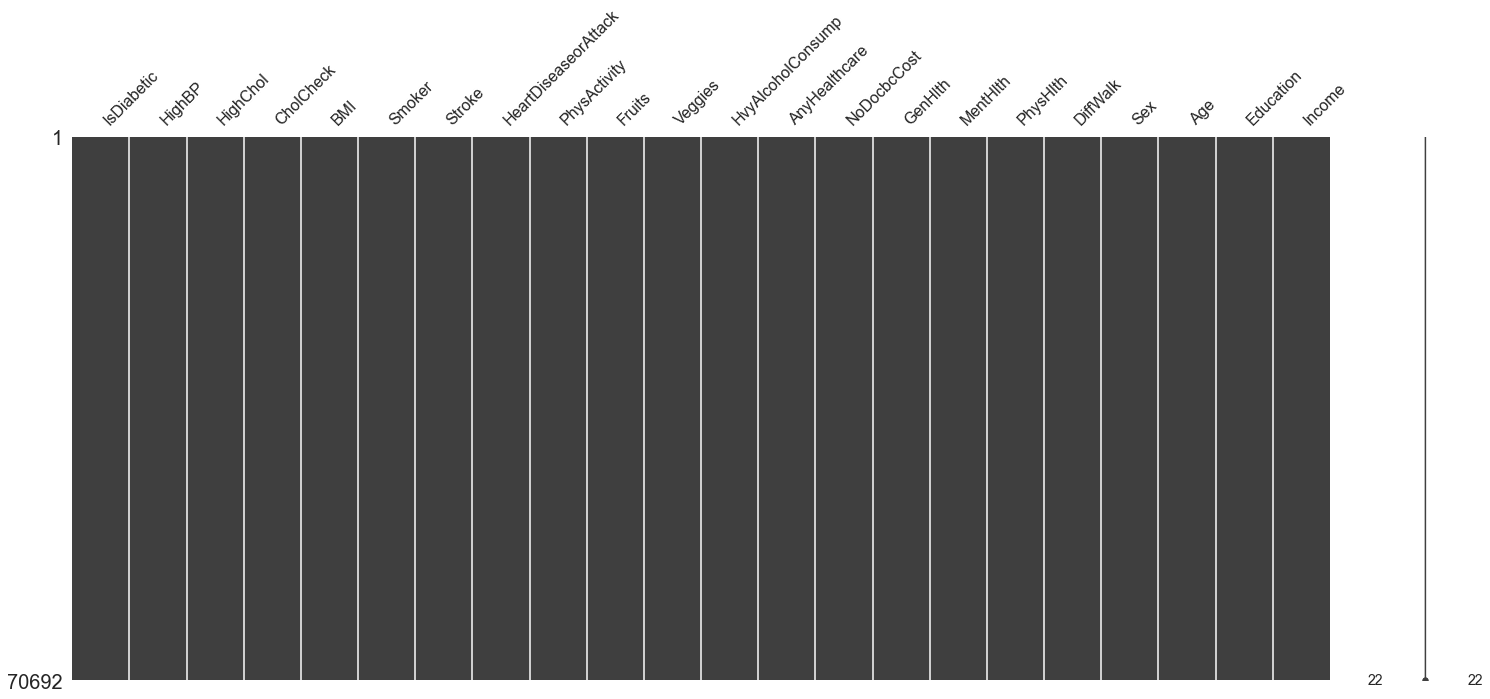

In [8]:
msno.matrix(data)
print(data.isna().sum())

**No missing Data! is this what happiness feels like**


![MEME](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyg42khl1j0QfL1ygYZUQJYbD4BGlG6C9jDA&usqp=CAU)

## 3. EDA

#### More on the Features

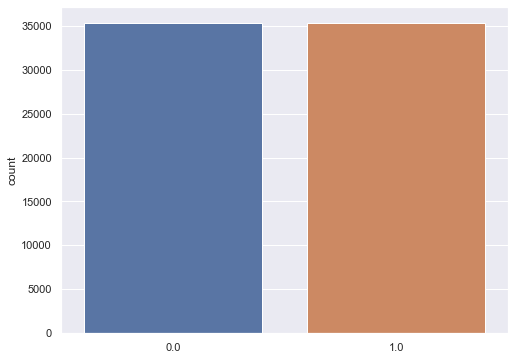

In [9]:
plt.figure(figsize = (8,6))
sns.countplot(x=data.IsDiabetic.values, data=data)
plt.show()

> From the above plot we can conclude that our data is in fact balanced

Next I want to check for corrolation

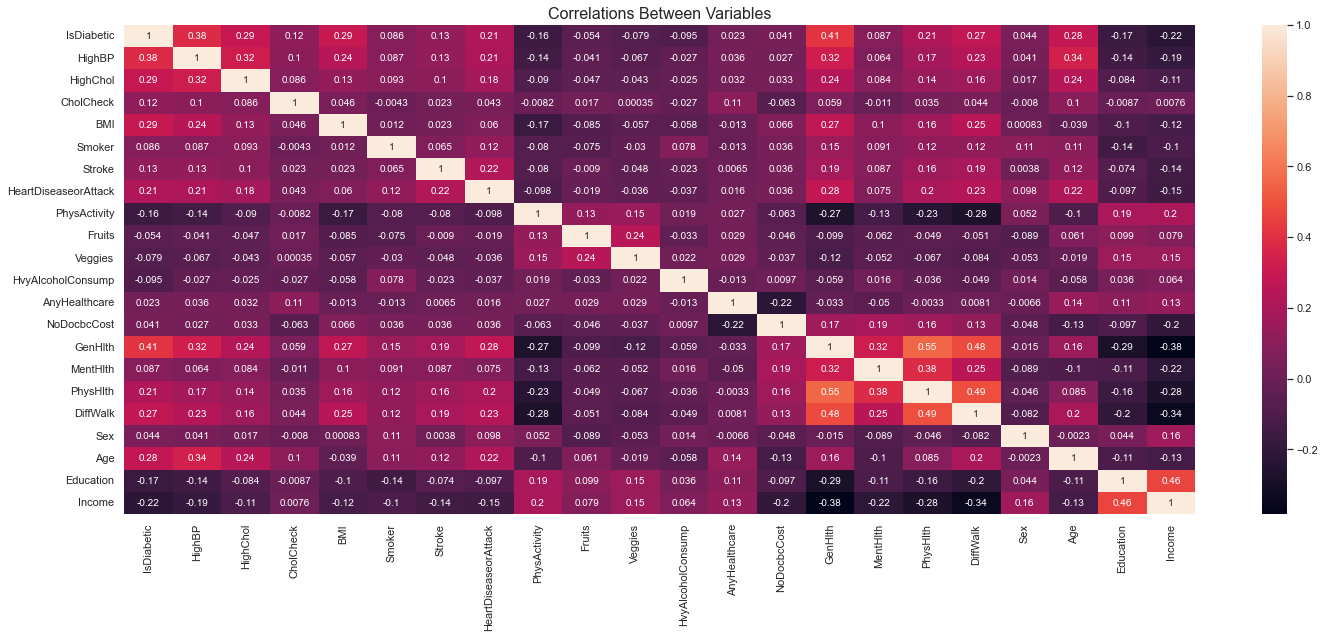

In [10]:
plt.figure(figsize=(24, 9))
sns.heatmap(data.corr(), annot=True)
plt.title("Correlations Between Variables", size=16)
plt.show()

From the above we can see that gen health has a very good corrolation for the person being diabetic. It also corrolates well to if a person has difficulty walking or his/her physical ability

Now next up we can start going through each feature and learn more on them.

Before that let me also just show you each column and the data creators notes on them:

1. IsDiabetic : 0 = no diabetes 1 = pre-diabetes or diabetes
2. HighBP : 0 = no high BP 1 = high BP
3. HighChol : 0 = no high cholesterol 1 = high cholesterol
4. CholCheck : 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years
5. BMI : Body Mass Index
6. Smoker : Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes
7. Stroke : (Ever told) you had a stroke. 0 = no 1 = yes
8. HeartDiseaseorAttack : coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes
9. PhysActivity : physical activity in past 30 days - not including job 0 = no 1 = yes
10. Fruits : Consume Fruit 1 or more times per day 0 = no 1 = yes
11. Veggies : Consume Vegetables 1 or more times per day 0 = no 1 = yes
12. HvyAlcoholConsump : (adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes
13. AnyHealthcare : Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes
14. NoDocbcCost : Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes
15. GenHlth : Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor
16. MentHlth : days of poor mental health scale 1-30 days
17. PhysHlth : physical illness or injury days in past 30 days scale 1-30
18. DiffWalk : Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes
19. Sex : 0 = female 1 = male
20. Age : 13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older
21. Education : Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = elementary etc.
22. Income : Income scale (INCOME2 see codebook) scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more

### 3.1 Univariant Analysis

In [11]:
# seperation of features
feature_classification = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "GenHlth",
    "DiffWalk",
    "Sex",
    "Age",
    "Education",
    "Income",
    "MentHlth",
    "PhysHlth",
]

feature_regression = [
    "BMI",
]

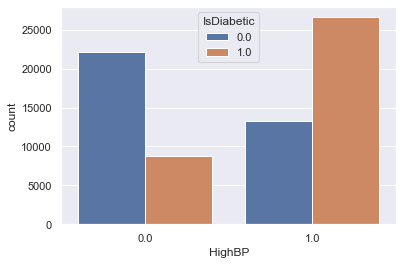

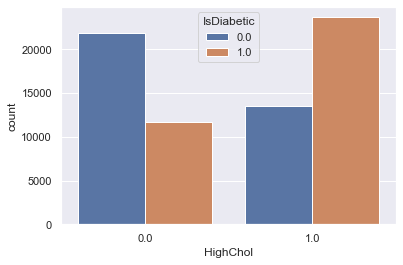

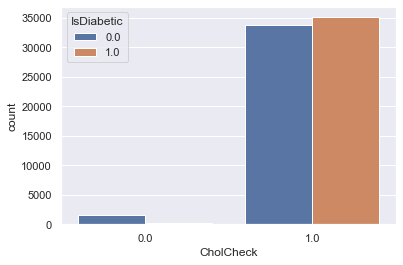

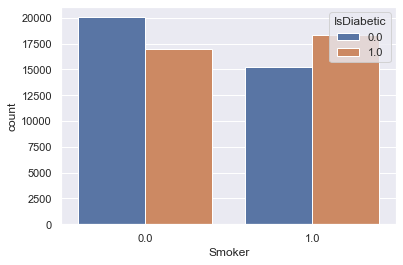

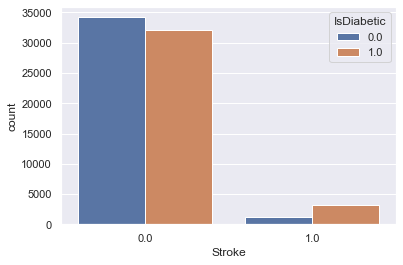

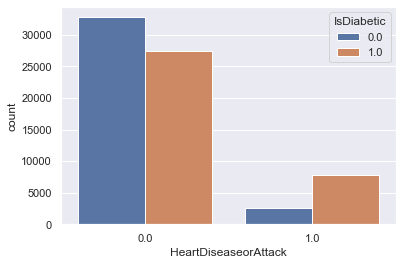

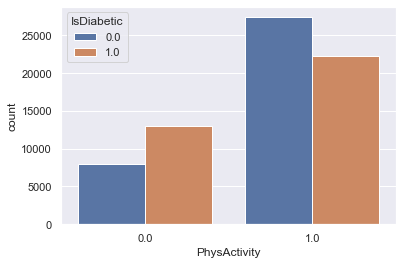

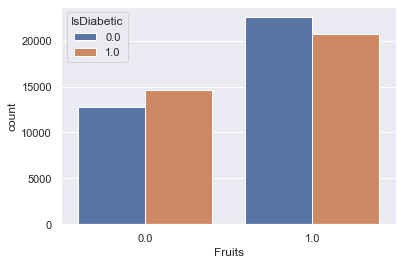

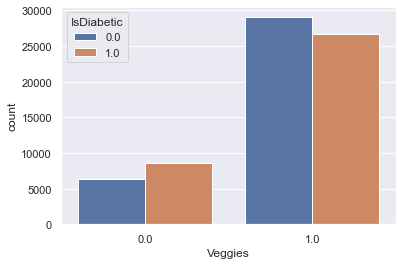

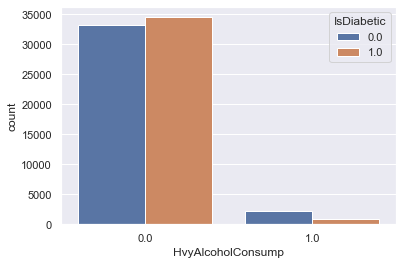

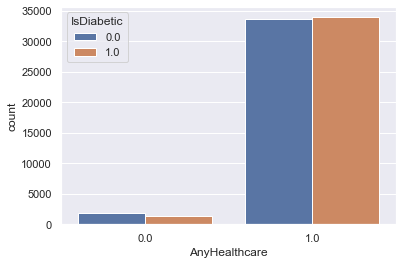

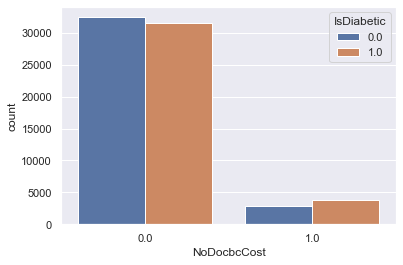

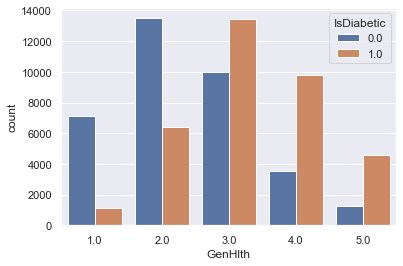

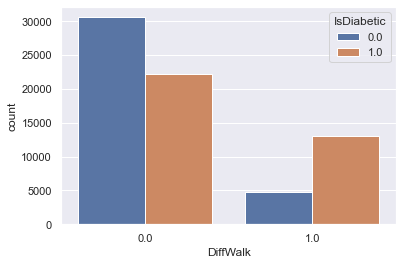

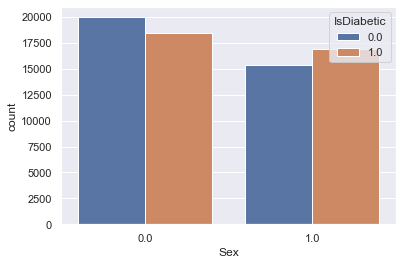

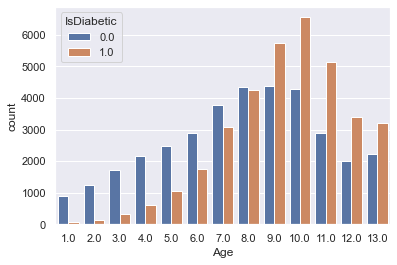

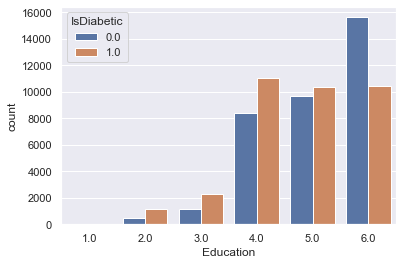

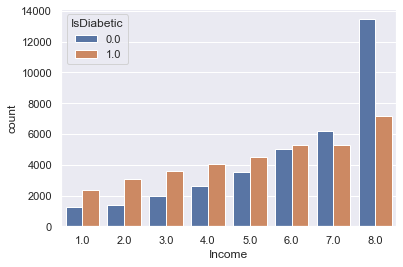

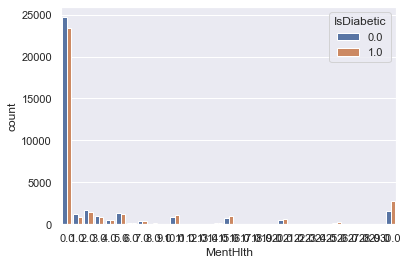

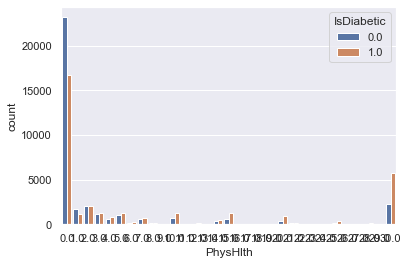

In [12]:
for feature in feature_classification:
    sns.countplot(data=data, x=feature, hue="IsDiabetic")
    plt.show()

From the Above we can see that physical activities can realy affect the score and also income doesnt realy matter but you can see a huge increase in decline of diabetes when a persons income level is 8. And also the more educated a person the less risk of diabetes he has is also shown.

For Age it is shown that people between 60 and 74 are the most prone to diabetes

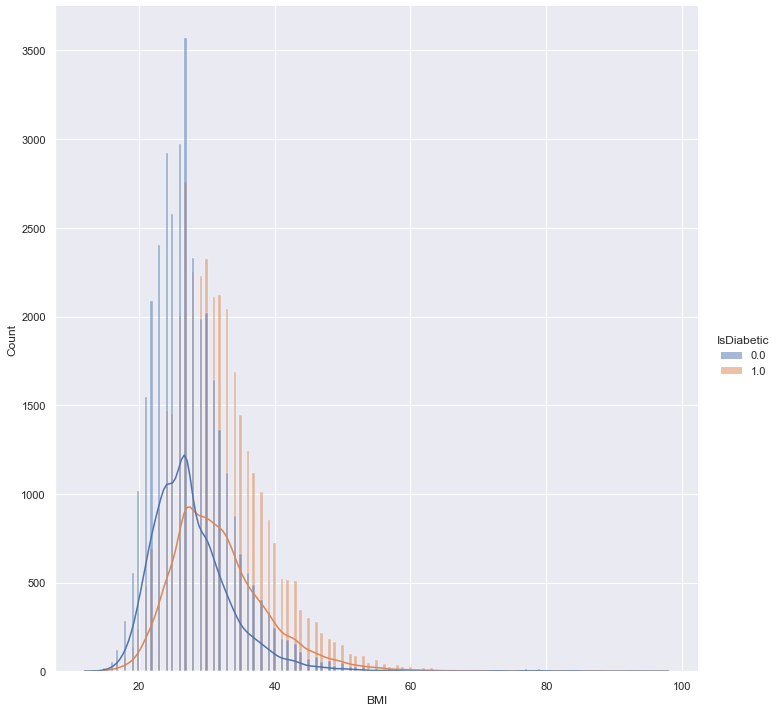

In [13]:
for feature in feature_regression:
    sns.displot(data=data, x=feature, kde=True, hue="IsDiabetic", height=10)
    plt.show()

From the above it is also abundantly clear that physical health and mental health realy do pay an important role in a patients diabetiness(new word!)

In [14]:
data.PhysHlth.value_counts()

0.0     39915
30.0     7953
2.0      4102
1.0      2853
3.0      2438
5.0      2332
10.0     1980
15.0     1913
4.0      1376
7.0      1326
20.0     1292
14.0      802
25.0      557
6.0       447
8.0       276
21.0      229
28.0      211
12.0      205
29.0       95
9.0        55
18.0       50
16.0       50
17.0       35
27.0       34
22.0       31
23.0       27
26.0       26
13.0       26
24.0       24
11.0       22
19.0       10
Name: PhysHlth, dtype: int64

Interestingly in second place with almost 8000 people we have the people who said that they had a full month of bad physical condition. Yikes!

In third place we have people with only 2 daya followed by people with  only 1. In first with arounf 40000 we have people who are fit and healthy.

**But** oh my did this series give a new nightmare about growing up

### 3.2 Bi-variant Analysis

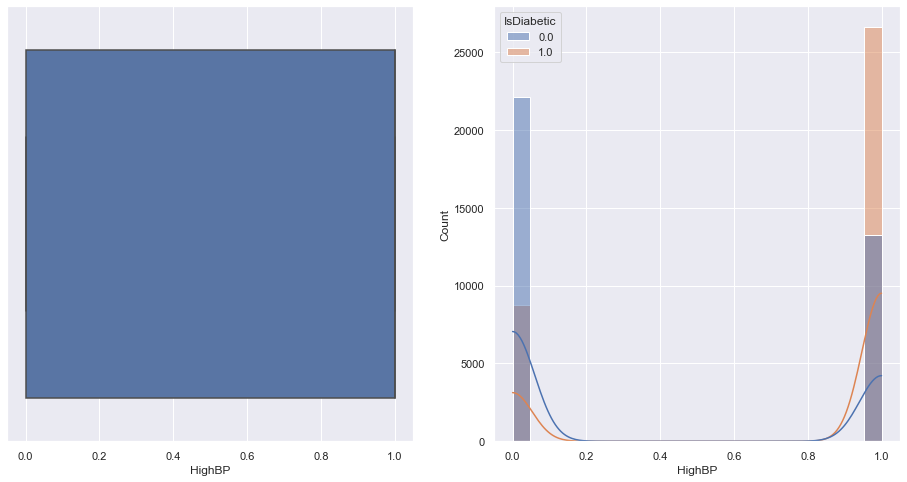

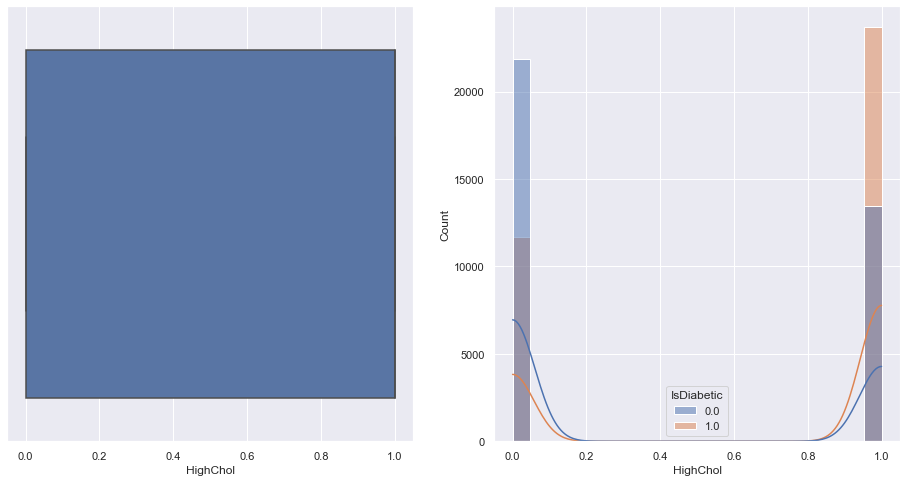

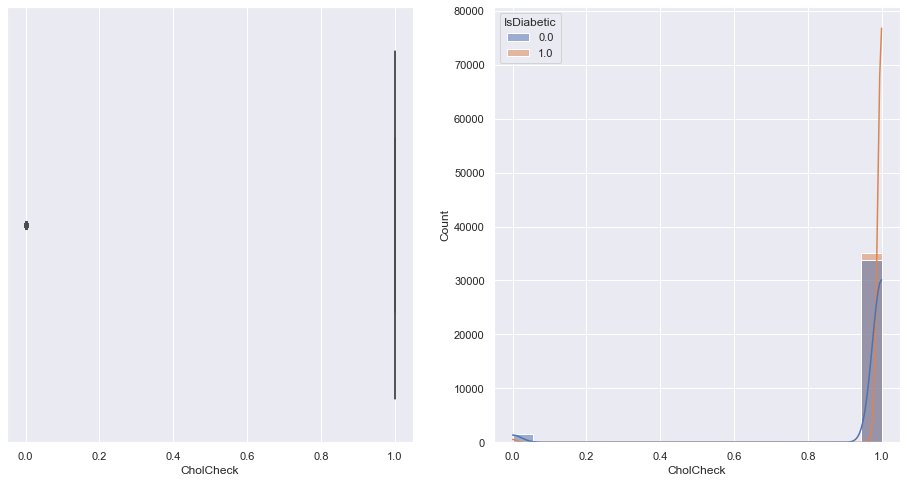

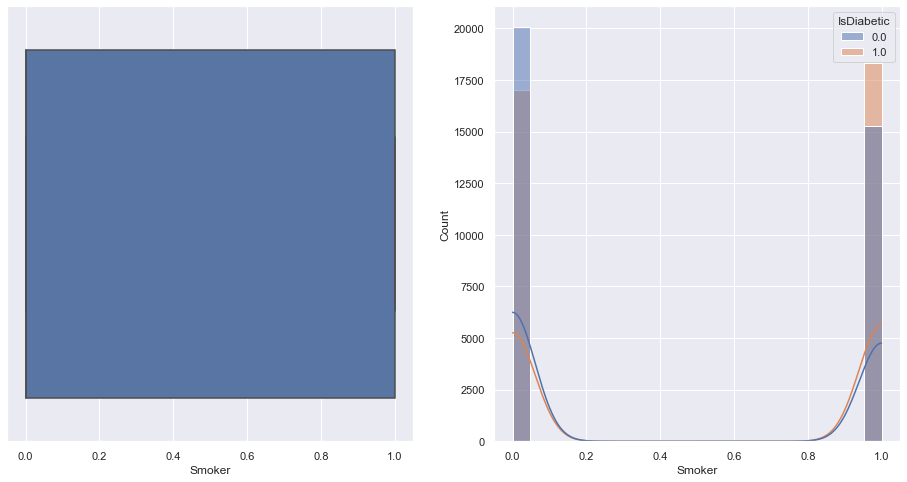

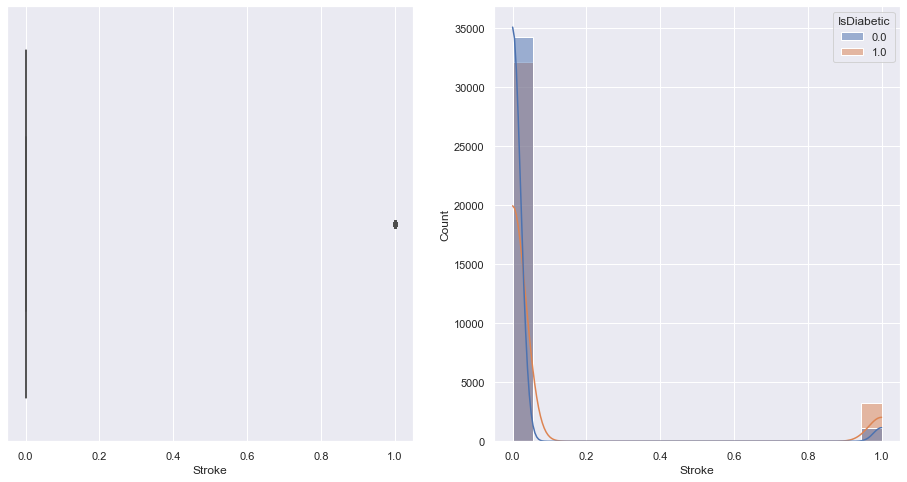

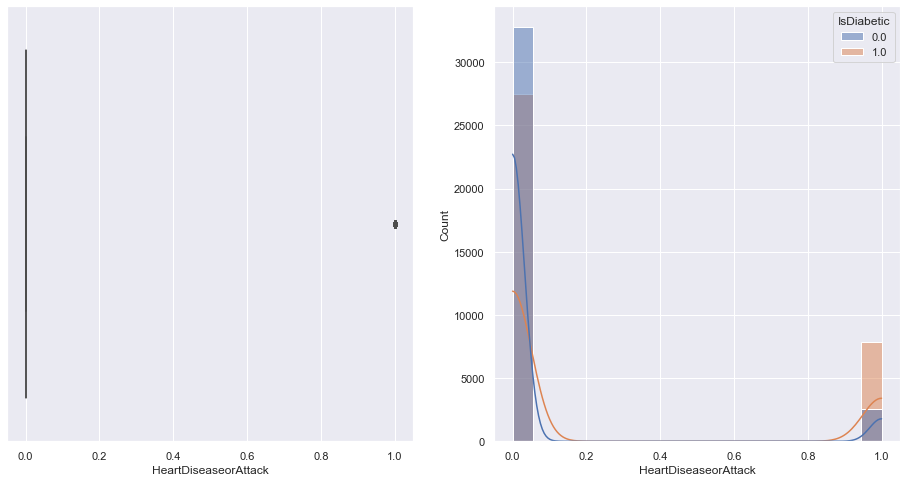

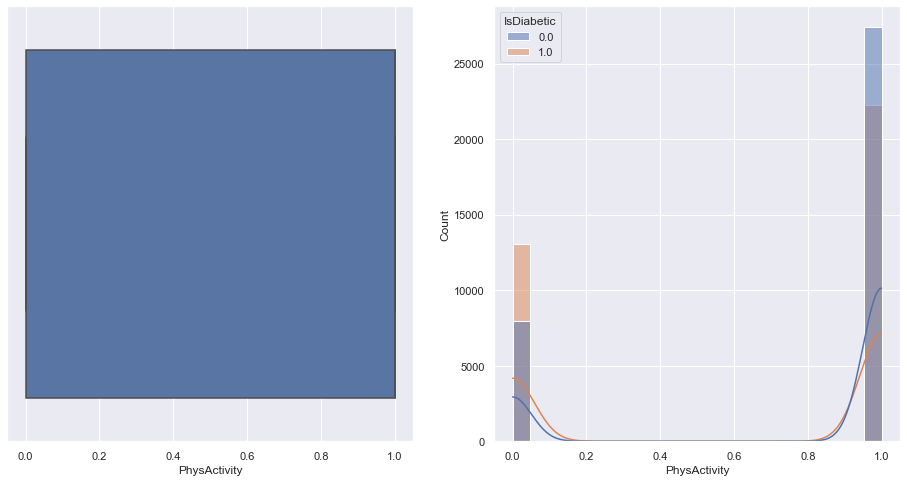

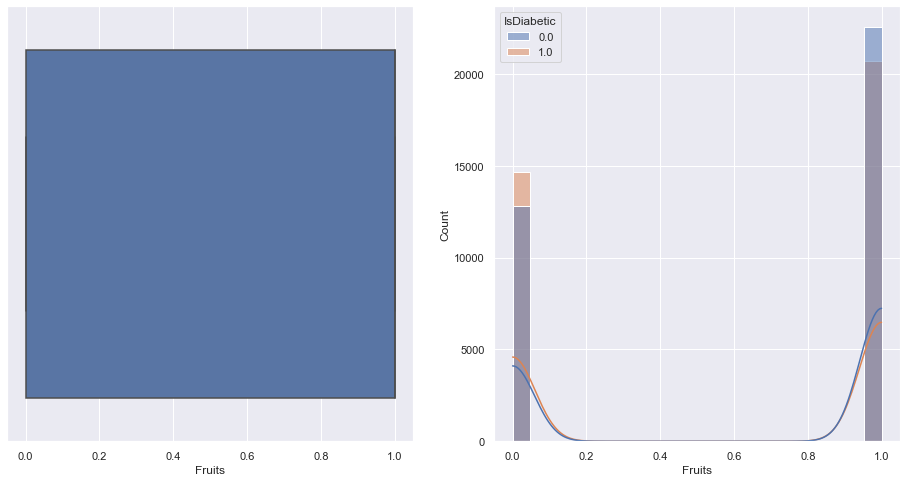

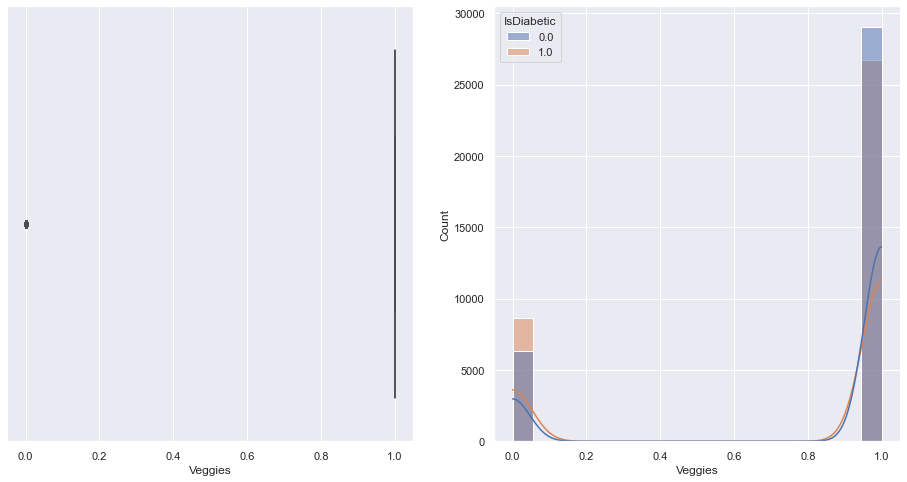

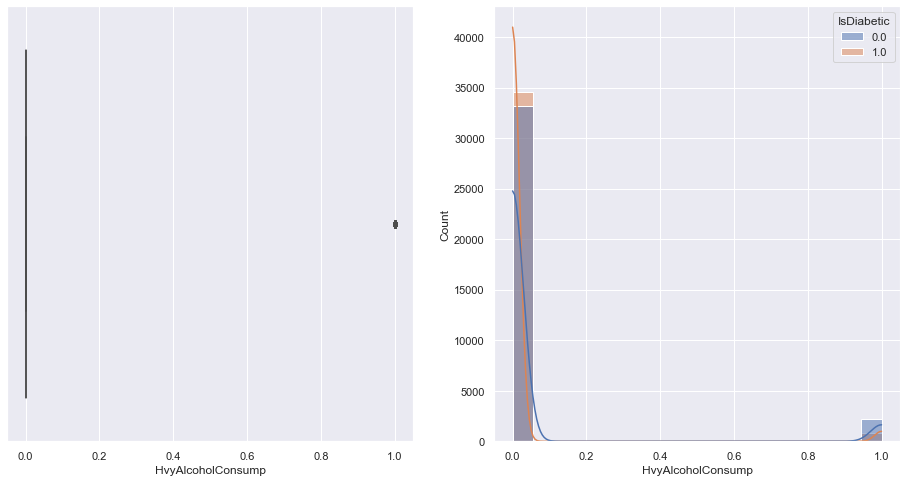

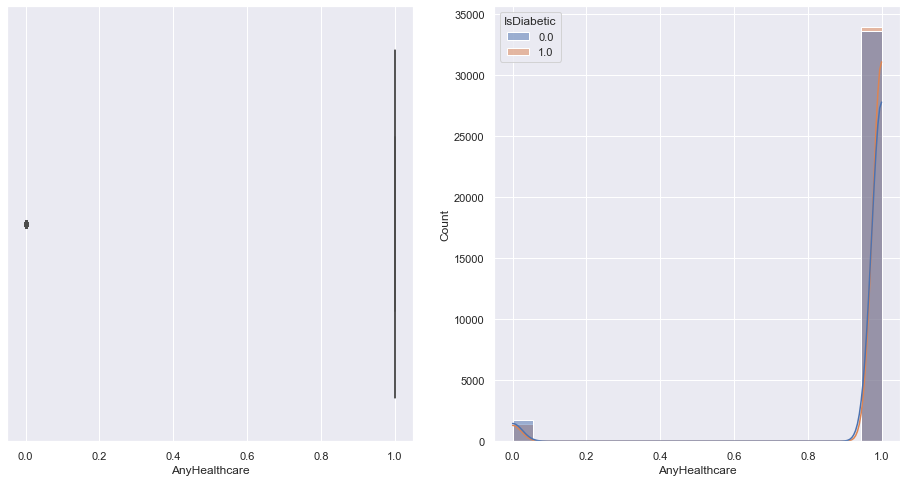

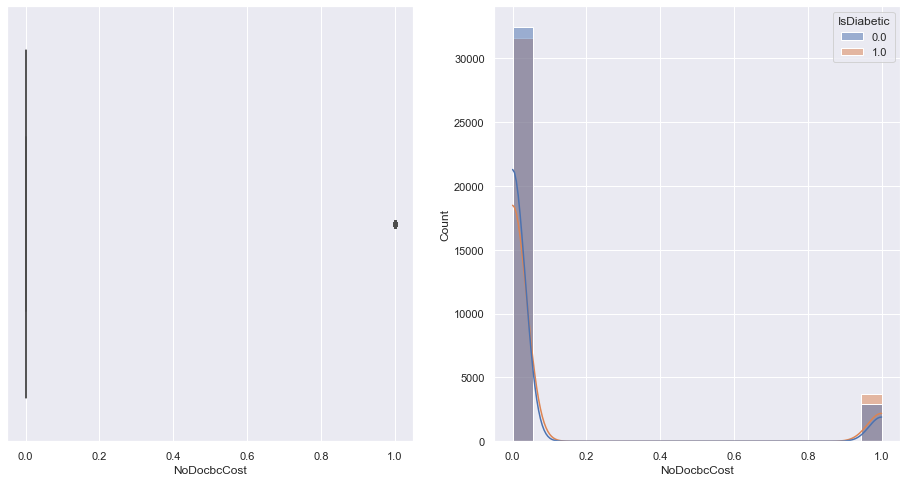

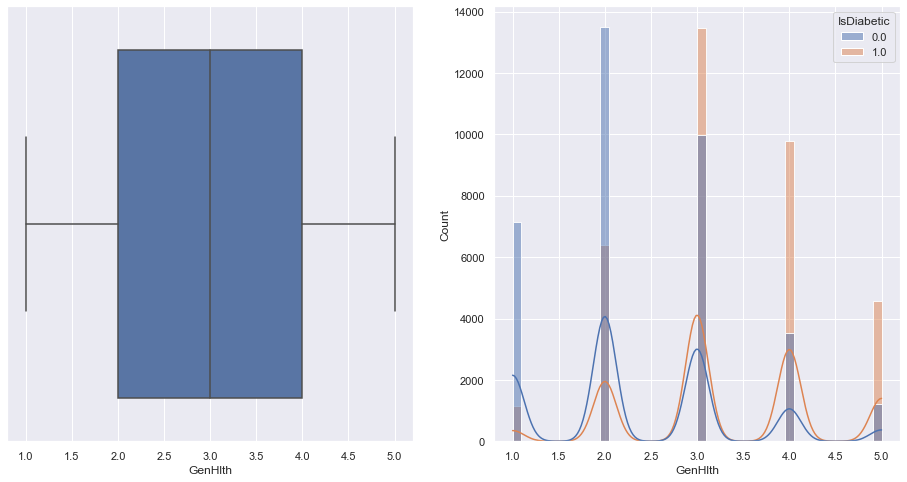

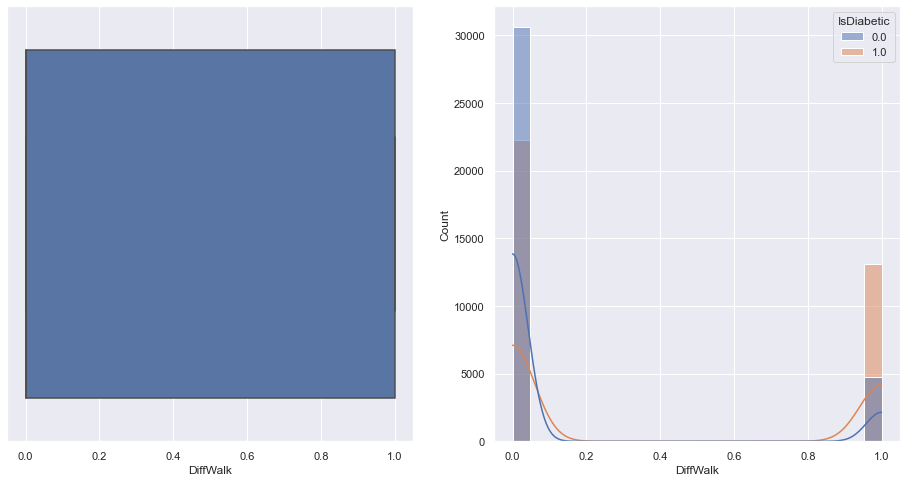

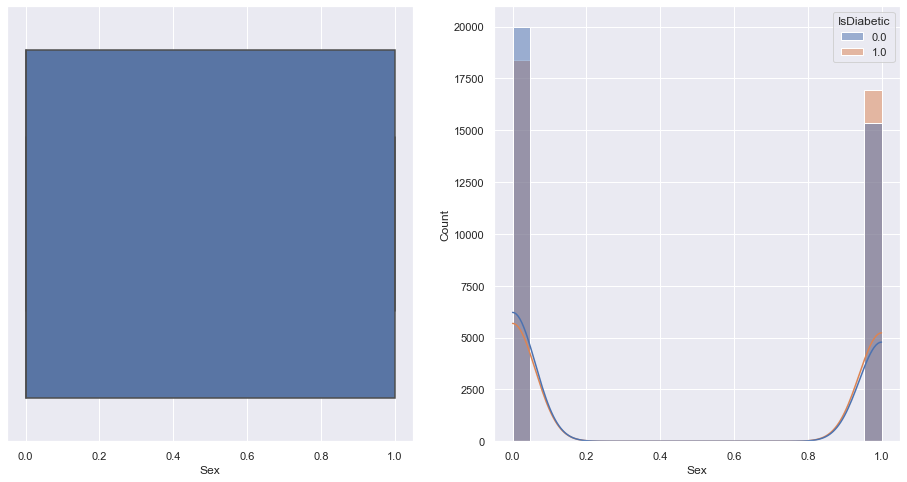

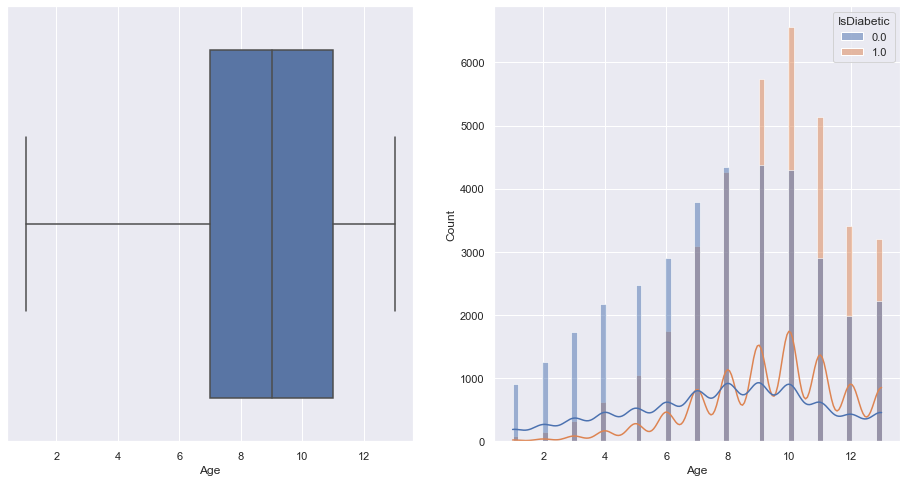

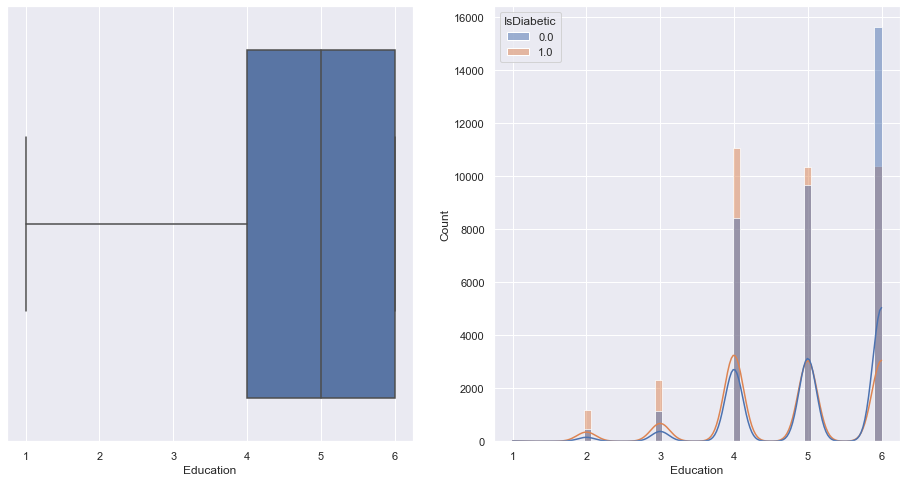

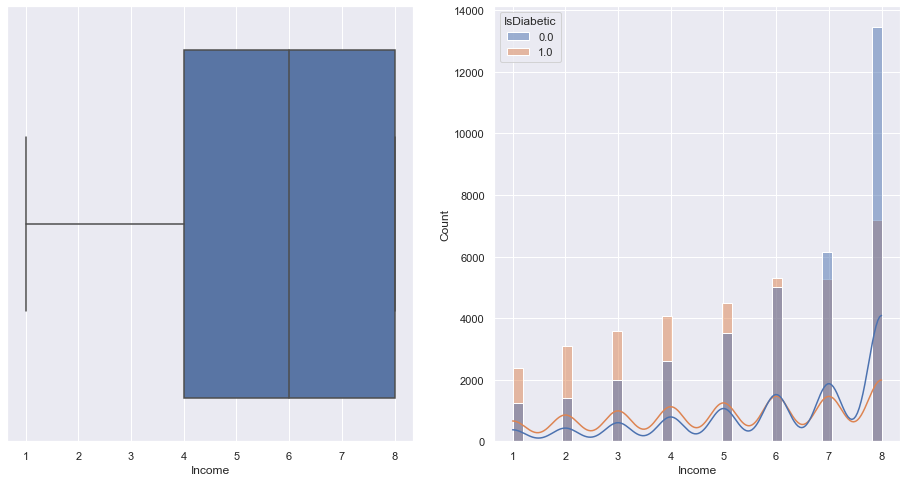

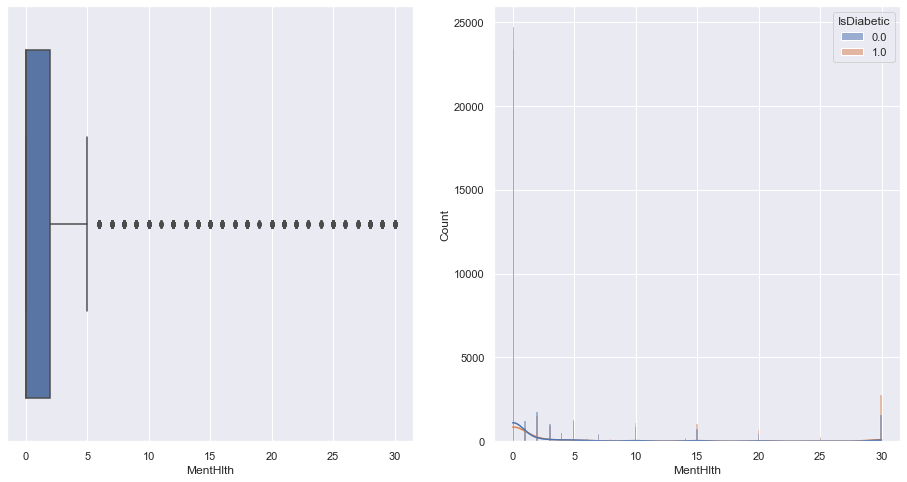

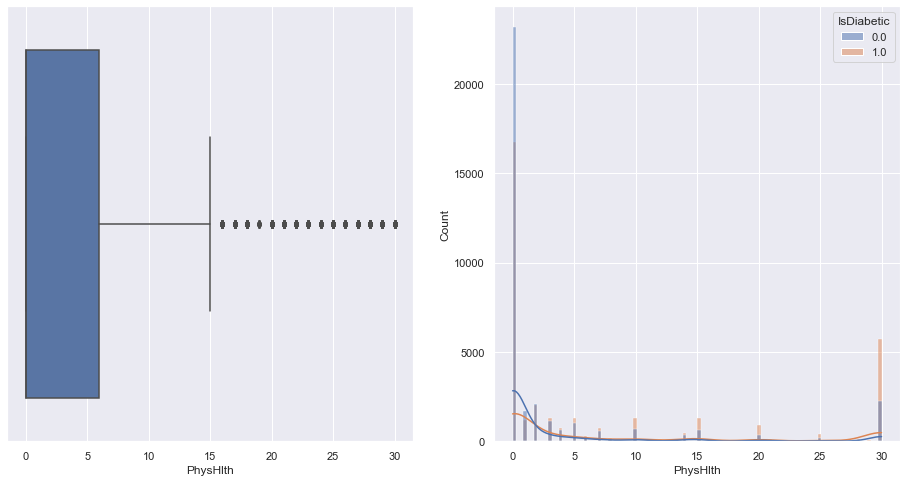

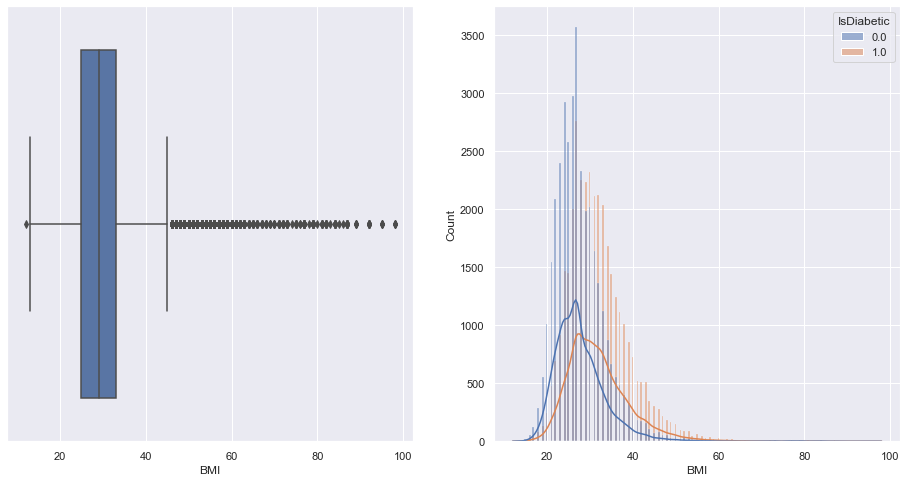

In [15]:
features = feature_classification + feature_regression

for i, feature in enumerate(features):
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    sns.boxplot(x=feature, ax = ax[0], hue="IsDiabetic", data=data)
    sns.histplot(x=feature, ax = ax[1], hue="IsDiabetic", kde=True, data=data)
    
    plt.show()


***Observations***

1. Fruits andd Veggiees are important
2. Alchol is not important

### 3.3 Feature importance

One Last thing before moving to summary and moving on to modeling i want to look at the feature importance.

These are my predictions after EDA:
 - GenHlth, PhysHlth, MentHlth and BMI should all be very high
 - Fruits, Veggies, education, age and income should also be high but not too high I would say
 - After looking some more in the data it seems DiffWalk can also be a major factor
 - Smoker, Stroke, Heartproblems and Any healthcare should be ranking very low
 - And yeah all the others should be somewhere inbetween

> For feature importance the method we just train a model and see its views on the data

> Here we will try 3 different models and so our results could be very different based on the model

> why could it be different you ask? Well its because each model trains in its own way with a different algorithm.
 And since the algo's are different then the result can also be different.

Steps Are:
1. Setup the Data for training
2. For each model
    - Train the model
    - Get its thaught on importance
    - Visualize it

***It so simple!***

**For this part contrary to what ive been using for plotting. I will use plotly because i want to see in details the info on each set!**

#### Step1. Setup DAta

In [16]:
X = data.drop(["IsDiabetic"], axis=1)
y = data["IsDiabetic"]

X_train, x_, y_train, _ = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_ = scaler.transform(x_)

#### Step2. Training

##### Method 1: From Coefficients

In [17]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})

importances = importances.sort_values(by='Importance', ascending=False)

fig = px.bar(importances, x="Attribute", y="Importance", text_auto=True)
fig.update_layout(barmode='relative', title_text="Feature importances obtained from coefficients")
fig.show()

It seems that the logistiic regression doesnt care about the PhysActivity, AnyHealthcare, NoDocbCost and smoking.

Education, Fruits, Mental Health, Veggies, PhysHlth, Income and HvyAlcoholic have a negative affect.

Otherwise GenHlth seems to be the most important in regards to diabeties foollowed by body mass, age HighBP and High Chol. And Sex does play a roole although its very minor.

Suprisingly DiffWalk unlike our prediction is doing terrible yikes!

> And so with feature importance method 1 test, we can see there is a huge difference between my predictions and the real result

#### Method 2: Importance from the trees

In [18]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

fig = px.bar(importances, x="Attribute", y="Importance", text_auto=True)
fig.update_layout(barmode='relative', title_text='Feature importances obtained from Trees')
fig.show()

Hm!. Huge difference can already be seen straight of the back. HighBP is the most important And GenHlth is in second. Do Note its not like a small lead HighBP is through the rooof.

The rest dont even keep up the 3rd place barely has a 5% say in the matter.

But a few similarities: PhysActivity, AnyHealthcare, and smoking are all realy low
Suprisingly here XGB doesnt care about the persons mental health.

In [19]:
# Method 3: PCA
pca = PCA().fit(X_train_scaled)

fig = px.line(y=pca.explained_variance_ratio_.cumsum(), title='Cumulative explained variance by number of principal components')
fig.show()

In [20]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
HighBP,0.493053,-0.423108,0.083929,-0.082350,0.020557,0.327682,0.197265,0.152999,0.018091,-0.023597,...,-0.074916,0.084275,0.085270,-0.119834,0.178541,0.415640,-0.260302,-0.189010,0.192842,0.067271
HighChol,0.383976,-0.376572,0.062026,0.039823,0.007856,0.326242,0.230225,0.209448,-0.128495,-0.402072,...,0.176265,0.116428,-0.222988,0.016888,-0.308095,-0.357052,0.040016,-0.066500,0.005459,0.023773
CholCheck,0.088158,-0.330044,-0.103115,-0.152924,0.219605,-0.034196,0.185121,-0.407871,-0.693274,0.262093,...,0.056788,-0.014095,-0.032822,0.026231,0.031856,0.001277,0.026350,-0.020449,-0.010560,0.006971
BMI,0.369766,0.022201,0.009060,-0.144806,0.486928,0.419782,0.094178,-0.006104,0.212992,0.344335,...,0.127079,0.022243,0.127342,0.196126,-0.017397,-0.028831,0.171449,0.171577,-0.134545,0.070287
Smoker,0.260608,-0.064733,0.275812,0.411394,-0.219973,-0.207445,0.299936,-0.383402,0.185290,-0.070482,...,0.450887,0.088146,0.215419,0.208650,0.095110,0.009067,-0.055289,-0.035127,-0.009520,0.006762


In [21]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

fig = px.bar(pc1_loadings, x="Attribute", y="CorrelationWithPC1", text_auto=True)
fig.update_layout(barmode='relative', title_text='PCA loading scores (first principal component)')
fig.show()

This time its not all that different from the first only here it seams a lot more considerate.

GenHlth is still in first and Income and deducation has an inverse relation

Astonishingly, this is pretty similar to my predictions and so yeah i was kinda right.

## EDA Summary

***Understanding***

People after getting diabetes thinking back on their mistakes:

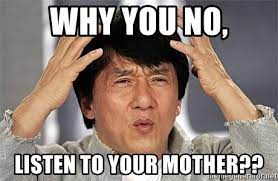

But in all seriousness though, the main thing is to just have a decent education goood money and a healthy life mentaly and physicaly *(all of which our moms told us about)*

*The Notes*

1. Or data is in fact balanced
2. Gn health has a very good corrolation for the person being diabetic. It also corrolates well to if a person has difficulty walking or his/her physical ability
3. From the Above we can see that wheter or not you do physical activities can realy affect the score
4. income doesnt realy matter but you can see a huge increase in decline of diabetes when a persons income level is 8
5. more educated a person the less risk of diabetes he has is also shown.
6. Age it is shown that people between 60 and 74 are the most prone to diabetes
7. it is now abundantly clear that physical health and mental health realy do pay an important role in a patients diabetiness(new word!)

Future Edit:
8. After a look through the features anyhealthcare noDocCbCost and CholCheck are 1 useless in my mind and 2 really doesnt help.

*Feature Importance Realization*
GenHlth seems to be the most important factor and also things like smoking and achoohol dont realy affect that much.

> Moving Forward I have now for the first time truly understood and realized my data.

### Next Plans
**I will only be removing three features(AnyHealthCare, NoDocCBCost and CholCHeck) from the dataset and keeping the rest**

Reason For Keeping remaining features:
    - mainly because after the results of the feature importance though it did show some features were not needed.In the end all the features do provide some help
    - also this being a model that predicts your life(in the sense of disease) it would be better  not to tamper with the data too much and use everything we've got

Reason For Removing 3 features
    - this to me is the dumbest feature in the dataset and i dont realy feel this will change much, and it doesnt realy change much

In [22]:
data = data.drop(['AnyHealthcare', 'NoDocbcCost', 'CholCheck'], axis=1)
data.shape

(70692, 19)

In [23]:
data.head()

,IsDiabetic,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


## 3. Modeling

Plan for modeling
1. Train All possible models
2. Evaluate the models an find the best
3. Get the Best and do fine tuning
4. Compare the tuned and the untuned moddels
5. On the final model check feature importance (this part is just because im curios)
6. Export the model with joblib

*During Phase 1 and 2 I will use a very limited amount of data of around 10000 rows*

And with that lets start coding!

#### Setting up the data

In [24]:
X, y =  data.drop(['IsDiabetic'], axis=1), data.IsDiabetic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Starting to Model

#### Step1. Training all possible Models

In [25]:

trainees = [
    { "name": "Logistic Regression", "model": LogisticRegression(random_state=42) },
    { "name": "Random Forest", "model": RandomForestClassifier(random_state=42) },
    { "name": "LightGBM", "model": LGBMClassifier(is_unbalance = False, random_state=42) },
    { "name": "Support Vector Machines", "model": SVC(random_state=42) },
    { "name": "XGBoost", "model": XGBClassifier(random_state=42) },
    { "name": "Gaussian Naive Bayes", "model": GaussianNB() },
    { "name": "Bernoulli Naive Bayes", "model": BernoulliNB() },
    { "name": "KNN", "model": KNeighborsClassifier(n_neighbors=3) },
    { "name": "Decision Tree", "model": DecisionTreeClassifier(random_state=42) },
    { "name": "Bagging Classifier", "model": BaggingClassifier(base_estimator=RandomForestClassifier(), random_state=42) },
]

for trainee_data in trainees:
    trainee_data["model"].fit(X_train, y_train)


#### Step 2. Evaluating the Models

In [26]:
accuracy   = pd.DataFrame(columns=["name", "accuracy"])
matrix = pd.DataFrame(columns=["name", "matrix"])
precision = pd.DataFrame(columns=["name", "precision"])
true_positive = pd.DataFrame(columns=["name", "true_positive_rate"])
specificity = pd.DataFrame(columns=["name", "specificity"])
f1_score_ = pd.DataFrame(columns=["name", "score"])
pr_score = pd.DataFrame(columns=["name", "score"])

In [27]:
for model_data in trainees:
    predictions = model_data['model'].predict(X_test)

    # 1. Confusion Metrics
    model_matrix = {"name": model_data["name"], "matrix": confusion_matrix(y_test, predictions, labels=[0, 1])}
    matrix = matrix.append(model_matrix, ignore_index=True)

    # 2. Accuracy
    model_acc = {"name": model_data["name"], "accuracy": accuracy_score(y_test, predictions)}
    accuracy = accuracy.append(model_acc, ignore_index=True)

    # 3. Precision
    model_pre = {"name": model_data["name"], "precision": precision_score(y_test, predictions)}
    precision = precision.append(model_pre, ignore_index=True)
    
    tn, fp, fn, tp = model_matrix["matrix"].ravel()

    # 4. Recall/Sensitivity/True Positive Rate
    model_tpr = {"name": model_data["name"], "true_positive_rate": tp / (tp + fn)}
    true_positive = true_positive.append(model_tpr, ignore_index=True)
    
    # 5. Specificity
    model_specificity = {"name": model_data["name"], "specificity": tp / (tp + fn)}
    specificity = specificity.append(model_specificity, ignore_index=True)
    
    # 6. F1 score
    model_f1_score = {"name": model_data["name"], "score": f1_score(y_test, predictions)}
    f1_score_ = f1_score_.append(model_f1_score, ignore_index=True)

print(" Accuracy ".center(80, "="))
print(accuracy.sort_values(by="accuracy", ascending=False))
print()
print(" Precision ".center(80, "="))
print(precision.sort_values(by="precision", ascending=False))
print()
print(" True Positive Rate ".center(80, "="))
print(true_positive.sort_values(by="true_positive_rate", ascending=False))
print()
print(" Specificity ".center(80, "="))
print(specificity.sort_values(by="specificity", ascending=False))
print()
print(" F1 Score ".center(80, "="))
print(f1_score_.sort_values(by="score", ascending=False))
print()

=================================== Accuracy ===================================
                      name  accuracy
2                 LightGBM  0.753522
4                  XGBoost  0.748486
3  Support Vector Machines  0.747524
0      Logistic Regression   0.74611
9       Bagging Classifier  0.744412
1            Random Forest  0.734906
6    Bernoulli Naive Bayes  0.728512
5     Gaussian Naive Bayes  0.703389
7                      KNN   0.69824
8            Decision Tree   0.65535

================================== Precision ===================================
                      name precision
0      Logistic Regression  0.738189
5     Gaussian Naive Bayes  0.733316
2                 LightGBM  0.730362
4                  XGBoost   0.72797
6    Bernoulli Naive Bayes  0.727939
3  Support Vector Machines  0.725198
9       Bagging Classifier  0.724238
1            Random Forest  0.718612
7                      KNN  0.692645
8            Decision Tree   0.65827

======================

Based on the above for our final model we can use the lightgbm model as that is the best all round model. But just before we move on to fine-tuning I just want to really know more on the lightgbm model

> LightGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage.
It uses two novel techniques: Gradient-based One Side Sampling and Exclusive Feature Bundling (EFB) which fulfills the limitations of histogram-based algorithm that is primarily used in all GBDT (Gradient Boosting Decision Tree) frameworks. The two techniques of GOSS and EFB described below form the characteristics of LightGBM Algorithm. They comprise together to make the model work efficiently and provide it a cutting edge over other GBDT frameworks
Gradient-based One Side Sampling Technique for LightGBM:
Different data instances have varied roles in the computation of information gain. The instances with larger gradients(i.e., under-trained instances) will contribute more to the information gain. GOSS keeps those instances with large gradients (e.g., larger than a predefined threshold, or among the top percentiles), and only randomly drop those instances with small gradients  to retain the accuracy of information gain estimation. This  treatment can lead to a more accurate gain estimation than uniformly random sampling, with the same target sampling rate, especially when the value of information gain has a large range.

From [Geeks For Geeks](https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/#:~:text=LightGBM%20is%20a%20gradient%20boosting,model%20and%20reduces%20memory%20usage.&text=Gradient%2Dbased%20One%20Side%20Sampling%20Technique%20for%20LightGBM%3A,the%20computation%20of%20information%20gain.)

#### Step 3. Fine-Tuning

In [28]:
# Un-tuned model For Comparison
untuned_model = LGBMClassifier(
    is_unbalance = False,
    random_state=42
)

untuned_model.fit(X_train, y_train)

LGBMClassifier(is_unbalance=False, random_state=42)

In [29]:
# Fine-Tuning the Params

algo = 'lightgbm'

N_FOLDS = 5
MAX_EVALS = 10

def objective(params, n_folds = N_FOLDS):
    classifier = LGBMClassifier(is_unbalanced = False,
                                **params,
                                random_state=9700)
    scores = cross_val_score(classifier, X_train, y_train.values.ravel(), cv=n_folds, scoring='roc_auc')
    best_score = max(scores)
    loss = 1 - best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    'num_leaves':  hp.choice('num_leaves', range(50,100)),
    'max_bin':  hp.choice('max_bin', range(20,100)),
    'min_data_in_leaf':  hp.choice('min_data_in_leaf', range(300,1000)),
    'num_iterations':  hp.choice('num_iterations', range(100,1000)),
    'min_sum_hessian_in_leaf':  hp.choice('min_sum_hessian_in_leaf', range(20,60)),
    'max_depth':  hp.choice('max_depth', range(3,8)),
    'feature_fraction':  hp.uniform('feature_fraction', 0.2, 0.5),
    'subsample':  hp.uniform('subsample', 0.5, 0.9),
    'bagging_fraction':  hp.uniform('bagging_fraction', 0.5, 0.9),
    'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
    'lambda_l1':  hp.uniform('lambda_l1', 0.0001, 1),
    'lambda_l2':  hp.uniform('lambda_l2', 0.0001, 1)
}

tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

[LightGBM] [Warning] Unknown parameter: is_unbalanced 
[LightGBM] [Warning] feature_fraction is set=0.3147952069420875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3147952069420875
[LightGBM] [Warning] min_data_in_leaf is set=994, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=994
[LightGBM] [Warning] lambda_l1 is set=0.3561086923449856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3561086923449856
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.5236672587236146, subsample=0.8167277027934737 will be ignored. Current value: bagging_fraction=0.5236672587236146
[LightGBM] [Warning] lambda_l2 is set=0.31816529803342264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31816529803342264
[LightGBM] [Warning] Unknown parameter: is_unbalanced 
[LightGBM] [Warning] feature_fraction is se

In [30]:
# creating fine-tuned model

clf = LGBMClassifier(
    is_unbalanced = False,
    num_leaves = max(best['num_leaves'], 2),
    max_bin = max(best['max_bin'], 2),
    min_data_in_leaf = best['min_data_in_leaf'],
    min_sum_hessian_in_leaf = best['min_sum_hessian_in_leaf'],
    max_depth = best['max_depth'],
    feature_fraction = best['feature_fraction'],
    subsample = best['subsample'],
    bagging_fraction = best['bagging_fraction'],
    learning_rate = best['learning_rate'],
    lambda_l1 = best['lambda_l1'],
    lambda_l2 = best['lambda_l2'],
    random_state=42
)

clf.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.2606503400578027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2606503400578027
[LightGBM] [Warning] min_data_in_leaf is set=359, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=359
[LightGBM] [Warning] lambda_l1 is set=0.7199668266081025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7199668266081025
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=31, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=31
[LightGBM] [Warning] bagging_fraction is set=0.8666643293650695, subsample=0.8513920251290833 will be ignored. Current value: bagging_fraction=0.8666643293650695
[LightGBM] [Warning] lambda_l2 is set=0.41939387487279056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41939387487279056


LGBMClassifier(bagging_fraction=0.8666643293650695,
               feature_fraction=0.2606503400578027, is_unbalanced=False,
               lambda_l1=0.7199668266081025, lambda_l2=0.41939387487279056,
               learning_rate=0.07975277512323058, max_bin=44, max_depth=0,
               min_data_in_leaf=359, min_sum_hessian_in_leaf=31, num_leaves=38,
               random_state=42, subsample=0.8513920251290833)

In [31]:
# removing the previos models
accuracy = accuracy[0:0]
matrix = matrix[0:0]
precision = precision[0:0]
true_positive = true_positive[0:0]
specificity = specificity[0:0]
f1_score_ = f1_score_[0:0]
pr_score = pr_score[0:0]

for model_data in [('Un-tuned Model', untuned_model), ('Fine-tuned Model', clf)]:
    predictions = model_data[1].predict(X_test)

    # 1. Confusion Metrics
    model_matrix = {"name": model_data[0], "matrix": confusion_matrix(y_test, predictions, labels=[0, 1])}
    matrix = matrix.append(model_matrix, ignore_index=True)

    # 2. Accuracy
    model_acc = {"name": model_data[0], "accuracy": accuracy_score(y_test, predictions)}
    accuracy = accuracy.append(model_acc, ignore_index=True)

    # 3. Precision
    model_pre = {"name": model_data[0], "precision": precision_score(y_test, predictions)}
    precision = precision.append(model_pre, ignore_index=True)

    tn, fp, fn, tp = model_matrix["matrix"].ravel()

    # 4. Recall/Sensitivity/True Positive Rate
    model_tpr = {"name": model_data[0], "true_positive_rate": tp / (tp + fn)}
    true_positive = true_positive.append(model_tpr, ignore_index=True)

    # 5. Specificity
    model_specificity = {"name": model_data[0], "specificity": tp / (tp + fn)}
    specificity = specificity.append(model_specificity, ignore_index=True)

    # 6. F1 score
    model_f1_score = {"name": model_data[0], "score": f1_score(y_test, predictions)}
    f1_score_ = f1_score_.append(model_f1_score, ignore_index=True)

In [32]:
print(" Accuracy ".center(80, "="))
print(accuracy.sort_values(by="accuracy", ascending=False))
print()
print(" Precision ".center(80, "="))
print(precision.sort_values(by="precision", ascending=False))
print()
print(" True Positive Rate ".center(80, "="))
print(true_positive.sort_values(by="true_positive_rate", ascending=False))
print()
print(" Specificity ".center(80, "="))
print(specificity.sort_values(by="specificity", ascending=False))
print()
print(" F1 Score ".center(80, "="))
print(f1_score_.sort_values(by="score", ascending=False))
print()

=================================== Accuracy ===================================
               name  accuracy
0    Un-tuned Model  0.753522
1  Fine-tuned Model  0.751372

================================== Precision ===================================
               name precision
1  Fine-tuned Model  0.731117
0    Un-tuned Model  0.730362

============================== True Positive Rate ==============================
               name true_positive_rate
0    Un-tuned Model           0.804365
1  Fine-tuned Model           0.795771

================================= Specificity ==================================
               name specificity
0    Un-tuned Model    0.804365
1  Fine-tuned Model    0.795771

=================================== F1 Score ===================================
               name     score
0    Un-tuned Model   0.76558
1  Fine-tuned Model  0.762075



So from the it is pretty clear that the un-tuned LGBMClassifier is the better model compared to the tuned one

#### Step 5. Final Model & Feature importance

##### 5.1 The Model

In [33]:
model_1 = LGBMClassifier(
    is_unbalance = False,
    random_state=42
)

# training it on the whole dataset
model_1.fit(X, y)

LGBMClassifier(is_unbalance=False, random_state=42)

##### 5.2 Feature importance

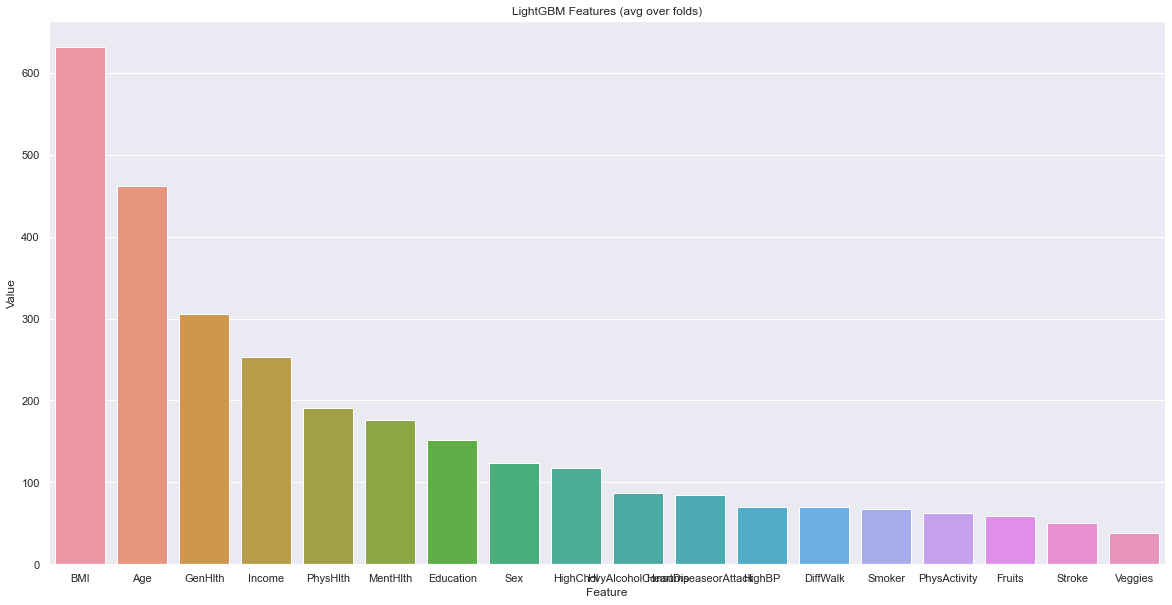

In [34]:
feature_imp = pd.DataFrame(sorted(zip(model_1.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Feature", y="Value", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

In [35]:
fig = px.bar(feature_imp, x="Feature", y="Value", text_auto=True)
fig.update_layout(barmode='relative', title_text='LightGBM Features (avg over folds)')
fig.show()

##### 5.3 Exporting the Model

In [36]:
joblib.dump(model_1, './kaggle/output/model_1_final.sav')

['./kaggle/output/model_1_final.sav']

**Finally im done with model 1 baby lets Gooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo!**

Now next up im going to start with the file 3 but before that I feel like working on the ui for some time so willl work on that and later come back here.

So finally after 7 days ive done finished the ui part of my website. So then now I decided to finally get back to my dead project.

# Model 2 (FILE 1)

But before I start let me save some old but important data

In [37]:
model_1_data = {
    "finale_model": model_1,
    "X": X.copy(),
    "y": y.copy(),
    "data": data.copy()
}


## Plan For Model 2
1. Import & go through Data
2. Remove Missing Data and Duplicates
3. Fix Imbalance
4. EDA
5. Feature Importance
6. Remove Unwanted Fields
7. Start testing for all possible models
8. Export model with joblib

> This part since its contains a lot of imbalenced data i will be reffering a lot to this [kaggle notebook](https://www.kaggle.com/code/mananrathod/diabetes-prediction-with-highest-accuracy-95-47) made by [MANAN RATHOD](https://www.kaggle.com/mananrathod)

## Step 1. Import & Go through Data

In [38]:
data = pd.read_csv(".\kaggle\input\diabetes-health-indicators-dataset\diabetes_012_health_indicators_BRFSS2015.csv")
data.shape

(253680, 22)

In [39]:
data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [41]:
data.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [42]:
# Changing the Diabetes_012 column to have a better column name
data = replace_data_name(data)

In [43]:
data.columns

Index(['IsDiabetic', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In File 3 Unlike File One there is a Whoping 2 Lack rows of data and out of data only 30 000 rows represent a patient having a type of diabetes. Because of this there is a huge major imbalence in this class and so later on we need to fix this.

## Step 2. Handling the Missing Values / Duplicates

IsDiabetic              0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

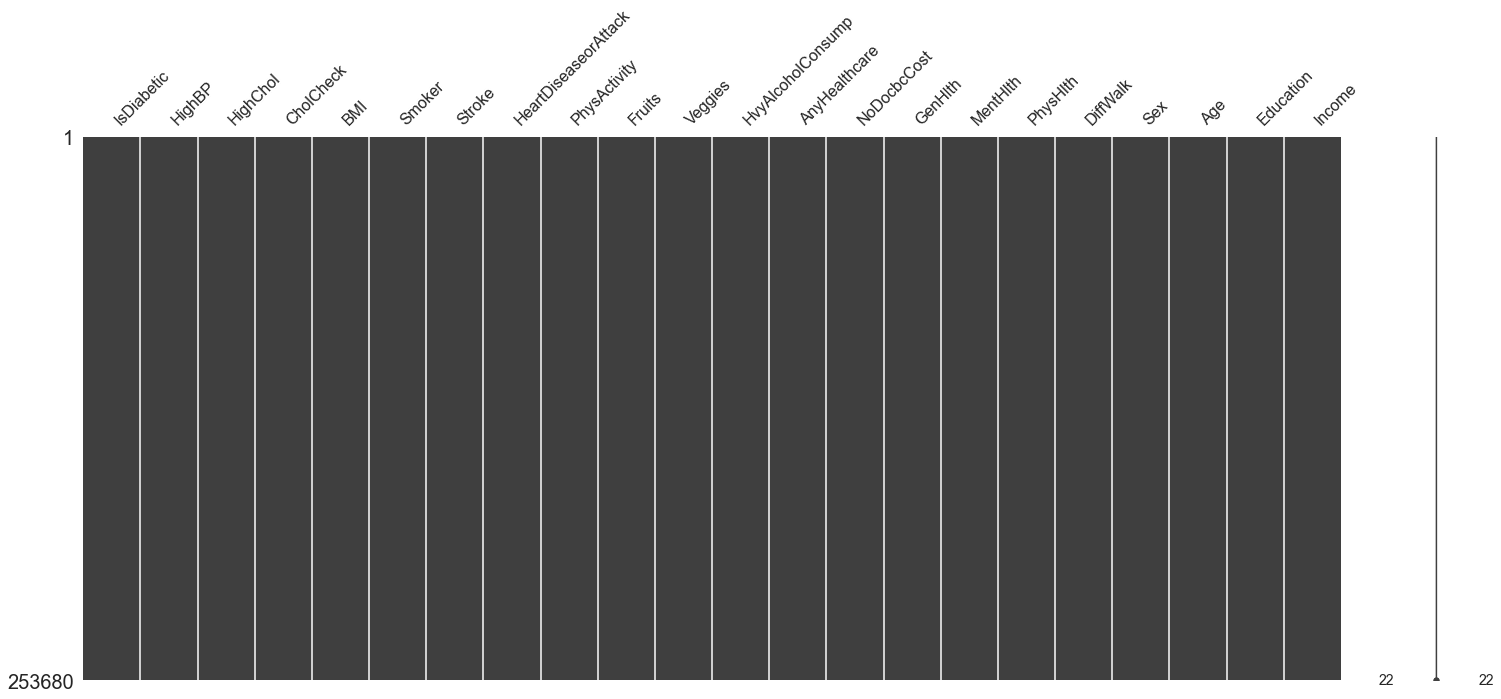

In [44]:
msno.matrix(data)
data.isna().sum()

Well since there is no missing data we can move on to the next part which is the duplicates.

In [45]:
duplicates = data[data.duplicated()]
print(f"Duplicate Rows : {duplicates}")

duplicates

Duplicate Rows :         IsDiabetic  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
1242           2.0     1.0       1.0        1.0  27.0     1.0     0.0   
1563           0.0     0.0       0.0        1.0  21.0     1.0     0.0   
2700           0.0     0.0       0.0        1.0  32.0     0.0     0.0   
3160           0.0     0.0       0.0        1.0  21.0     0.0     0.0   
3332           0.0     0.0       0.0        1.0  24.0     0.0     0.0   
...            ...     ...       ...        ...   ...     ...     ...   
253492         2.0     1.0       1.0        1.0  33.0     0.0     0.0   
253550         0.0     0.0       0.0        1.0  25.0     0.0     0.0   
253563         0.0     0.0       1.0        1.0  24.0     1.0     0.0   
253597         0.0     0.0       0.0        1.0  24.0     0.0     0.0   
253638         0.0     0.0       0.0        1.0  24.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
1242                     0.0    

,IsDiabetic,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
1242,2.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,2.0,1.0,1.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0


0.0    23648
2.0      249
1.0        2
Name: IsDiabetic, dtype: int64

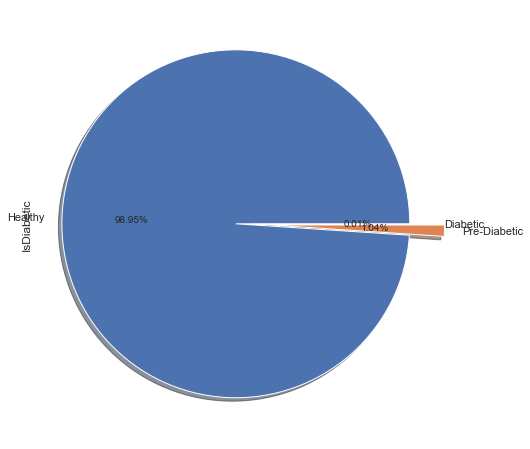

In [46]:
duplicates.IsDiabetic.value_counts().plot.pie(
    labels=['Healthy', 'Pre-Diabetic', 'Diabetic'],
    autopct='%1.2f%%',
    shadow=True,
    explode=[0.1, 0.1, 0],
    figsize=(8, 8)
)

duplicates.IsDiabetic.value_counts()

So great now we have foun 24000 rows of duplicate data which we can remove which puts our data to now have a bit under 2 30 000 which helps alot!

In [47]:
# Removing duplicate rows from the dataset
data.drop_duplicates(inplace = True)

In [48]:
data.shape

(229781, 22)

Now next up I can now start with the Balencing The Data

So now our data has gone from 253680 rows to just under 230000 rows.

## Step 3. Balancing the Data

For balancing the data I will be using the SMOTE method as i feel it is more efficient than a simple over sampeling method and gives more data without any duplicates so there should be no oversampeling (do tell if im wrong)

> DO Note: This is my very first time trying this algorithms so do tell if I can do it better as it would really help me learn more.

In [49]:
x, y = data.drop(['IsDiabetic'], axis=1), data.IsDiabetic

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)
data = x_smote.merge(y_smote.rename('IsDiabetic'), left_index=True, right_index=True)

data.shape

(570165, 22)

In [50]:
data.IsDiabetic.value_counts()

0.0    190055
2.0    190055
1.0    190055
Name: IsDiabetic, dtype: int64

Wow! Now my data almost double the amount before the sampeling. So now Next up im curios about my data so i will be doing some Eda

## Step 4. EDA

I will be doing mostly the same things I did last time but, since the data is a bit too much I might try and remove a lot of rows before trying. If a certain chart takes too long run then i will be using this new chart.

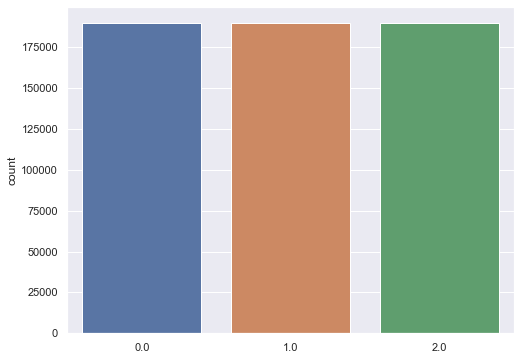

In [51]:
plt.figure(figsize = (8,6))
sns.countplot(x=data.IsDiabetic.values, data=data)
plt.show()

From this plot we can conclude that our data is in fact baclenced

In [52]:
# Setting up the cheat data
X = data.drop(["IsDiabetic"], axis=1)
y = data["IsDiabetic"]

x_, x, y_, y = train_test_split(X, y, test_size=0.50, random_state=42)

test_data = x.merge(y.rename("IsDiabetic"), left_index=True, right_index=True)

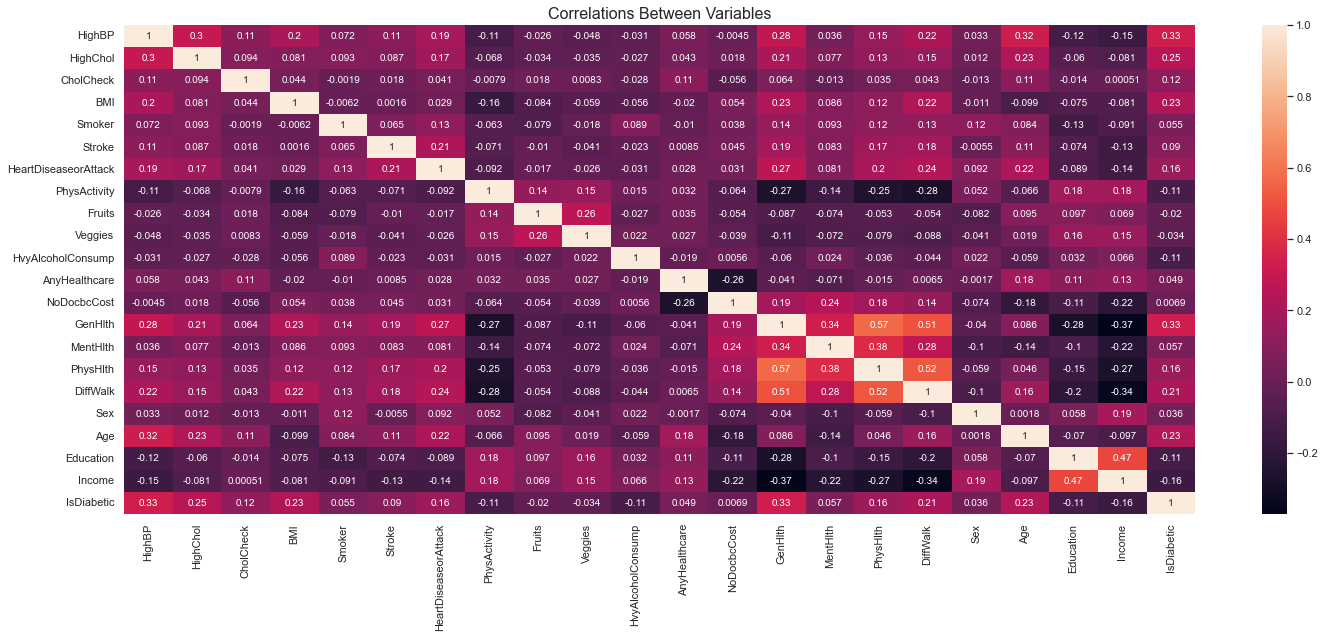

In [53]:
plt.figure(figsize=(24, 9))
sns.heatmap(data.corr(), annot=True)
plt.title("Correlations Between Variables", size=16)
plt.show()

One interesting to note here is that Gen Hlth, DiffWalk and PhysHlth all do have a very good corolation as before, in fact I would say not much has  changed as part of feature corolation.

For unknown reasons i wasnt able to get the univariant eda to work and so ive skiped it.

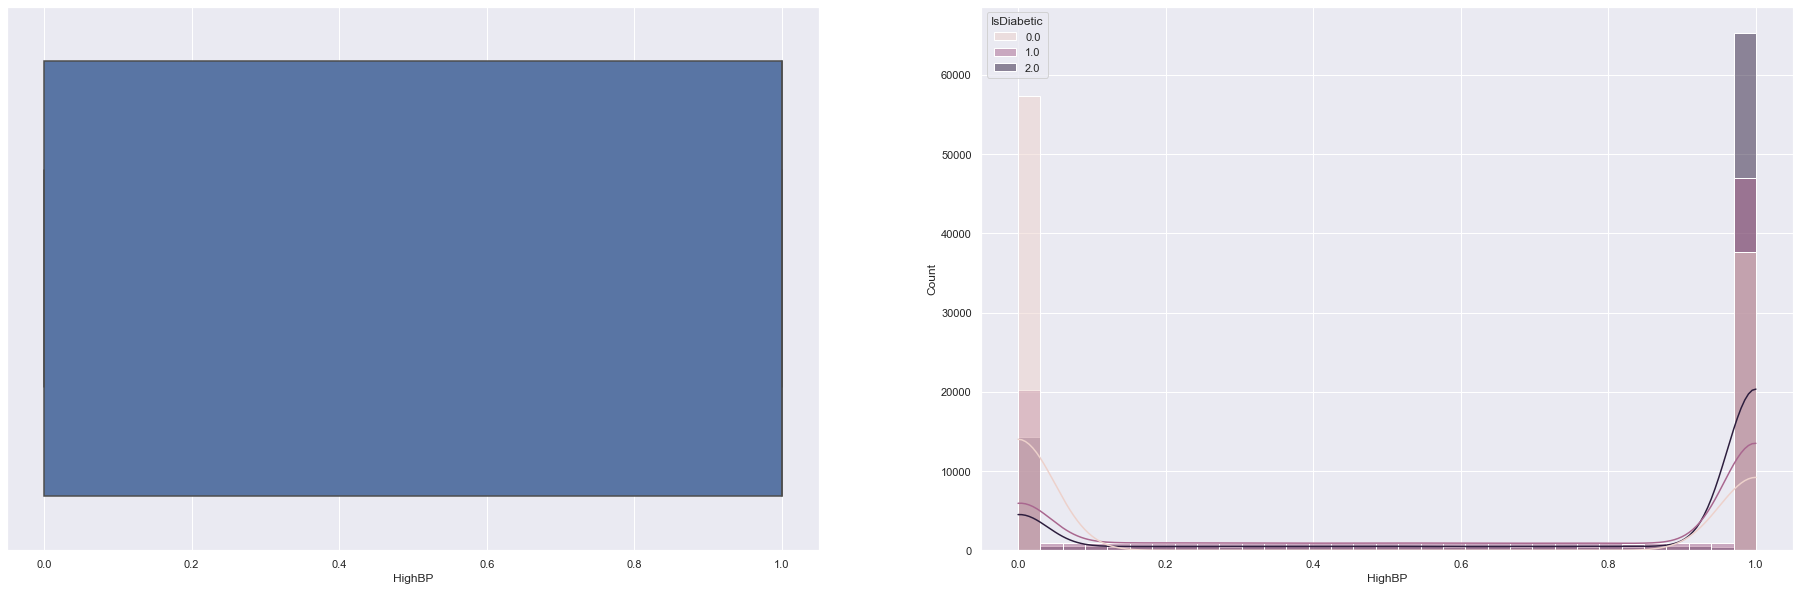

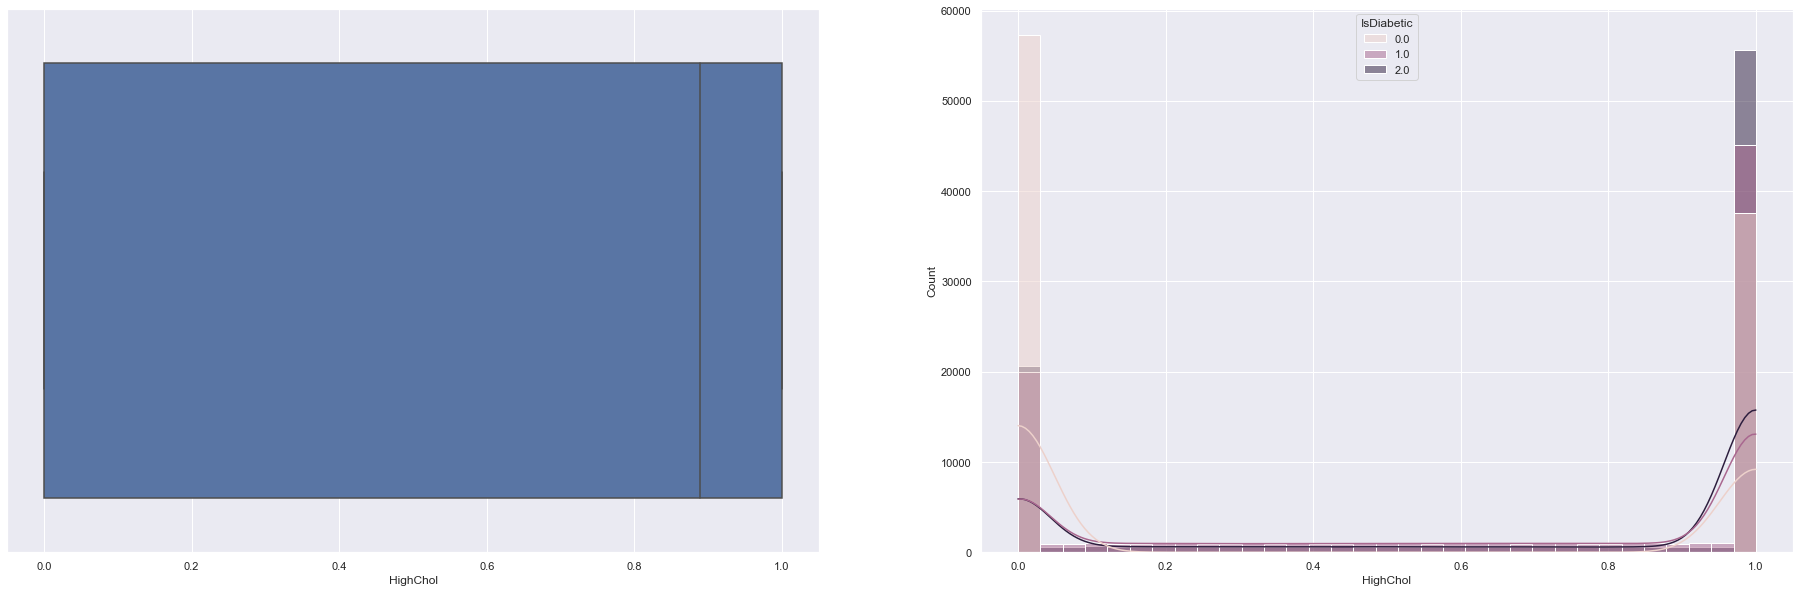

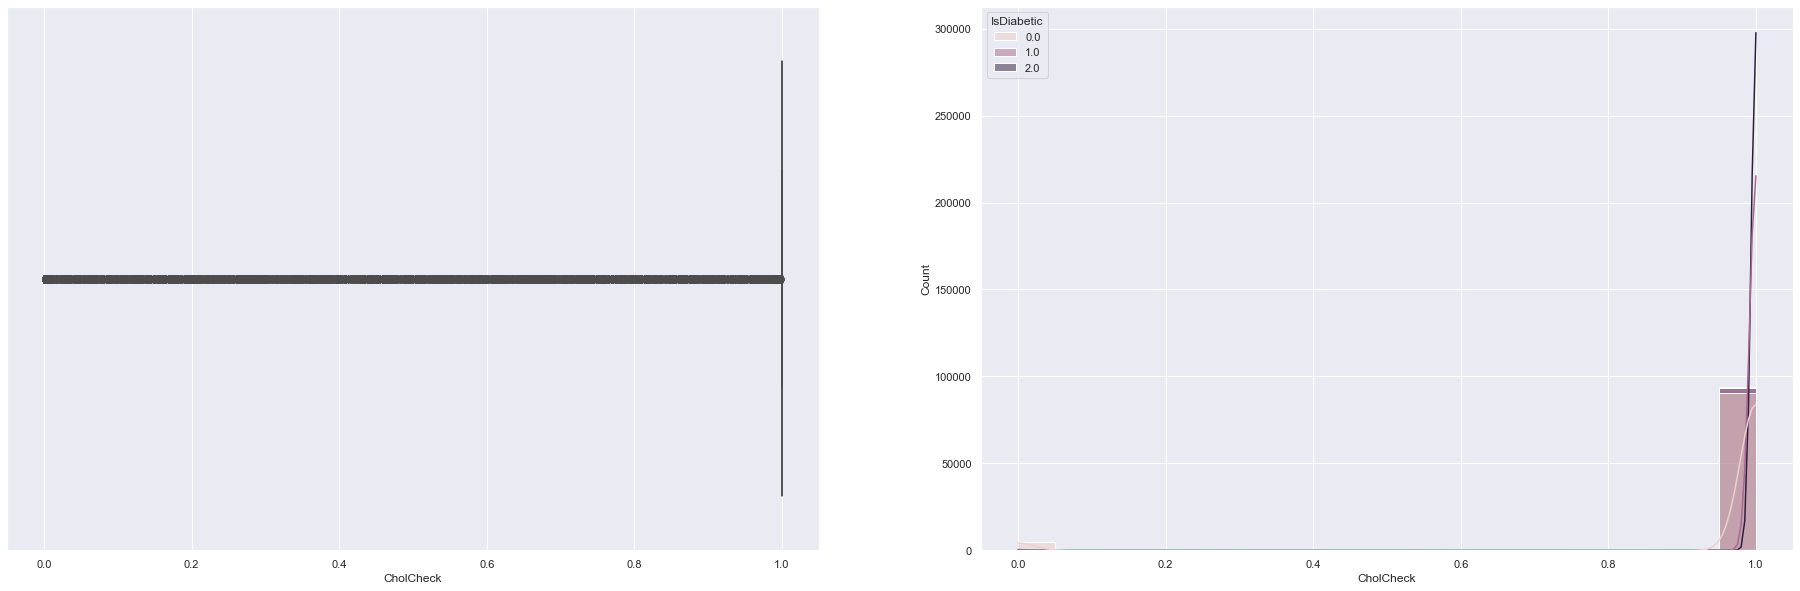

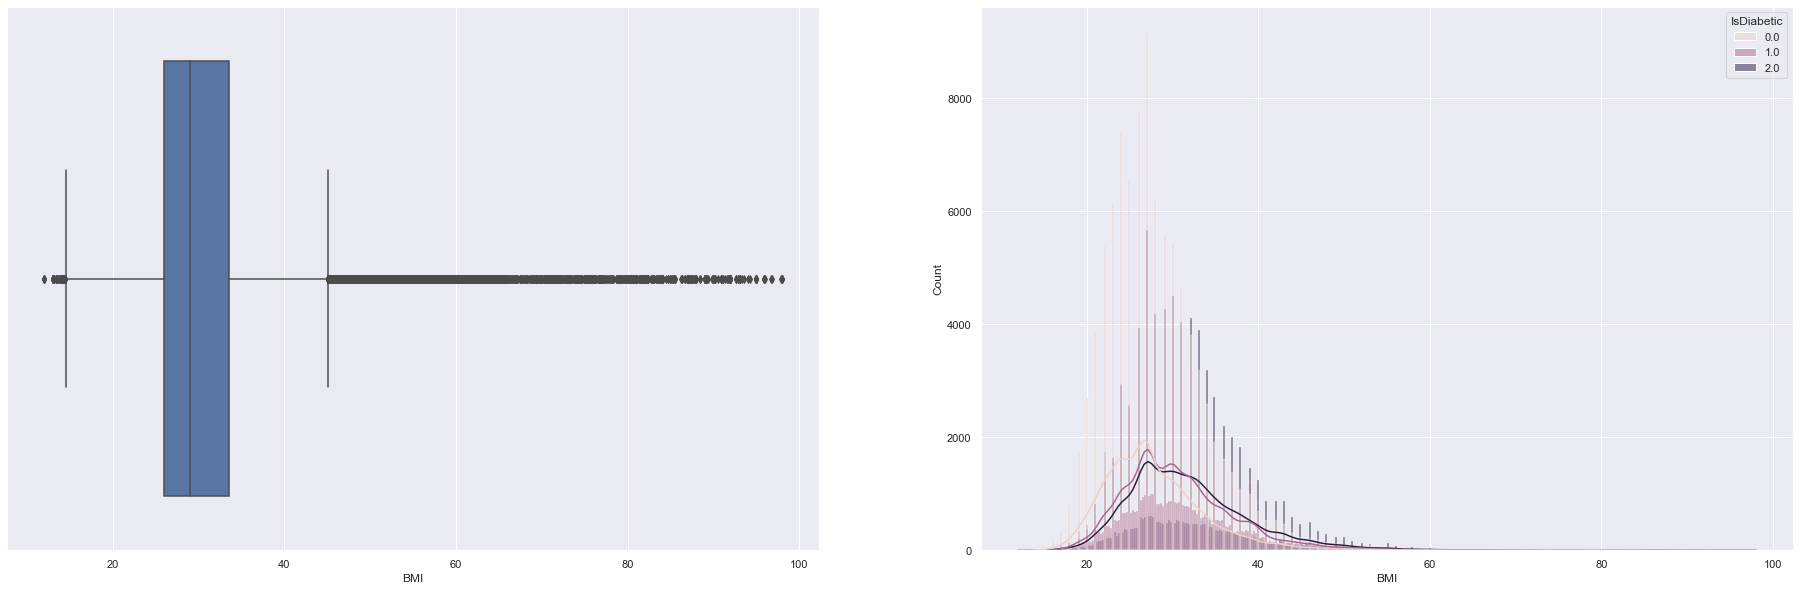

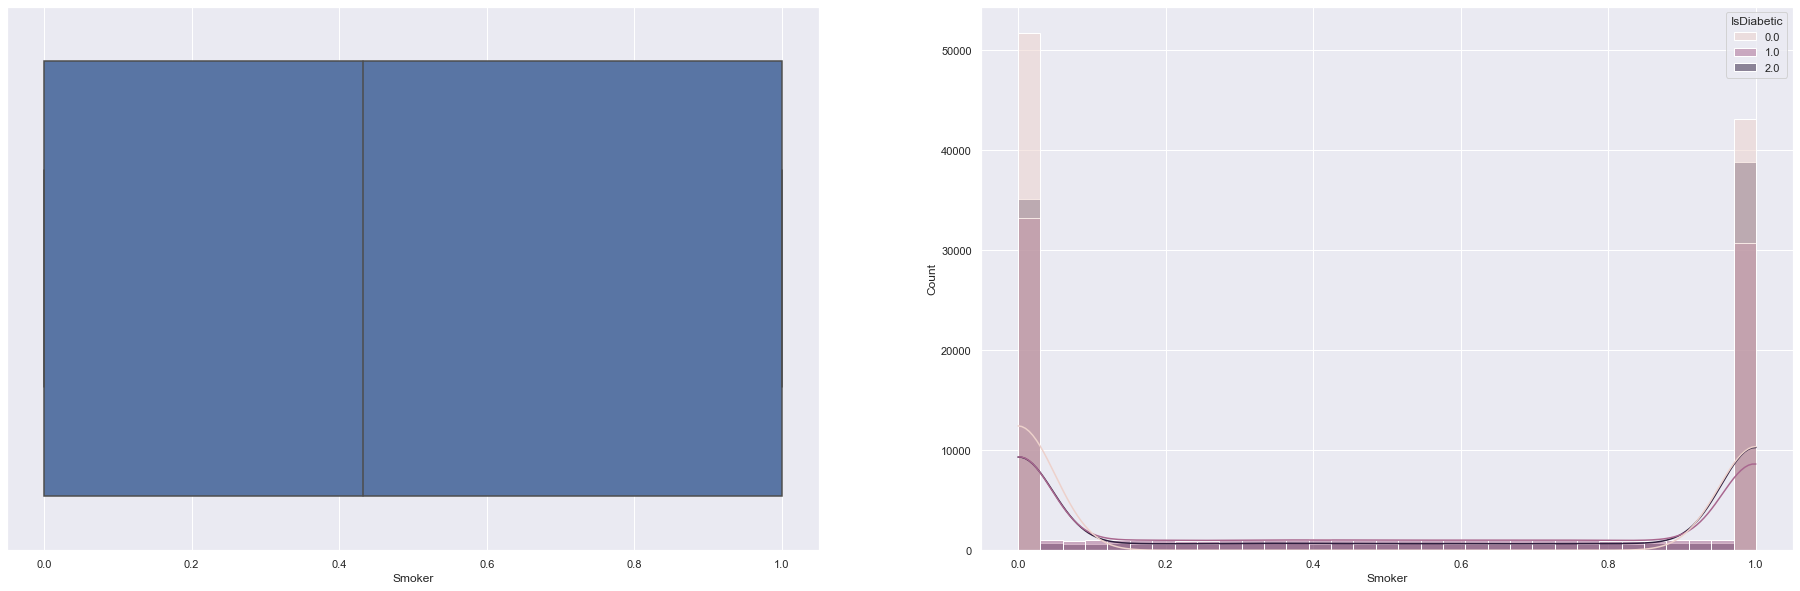

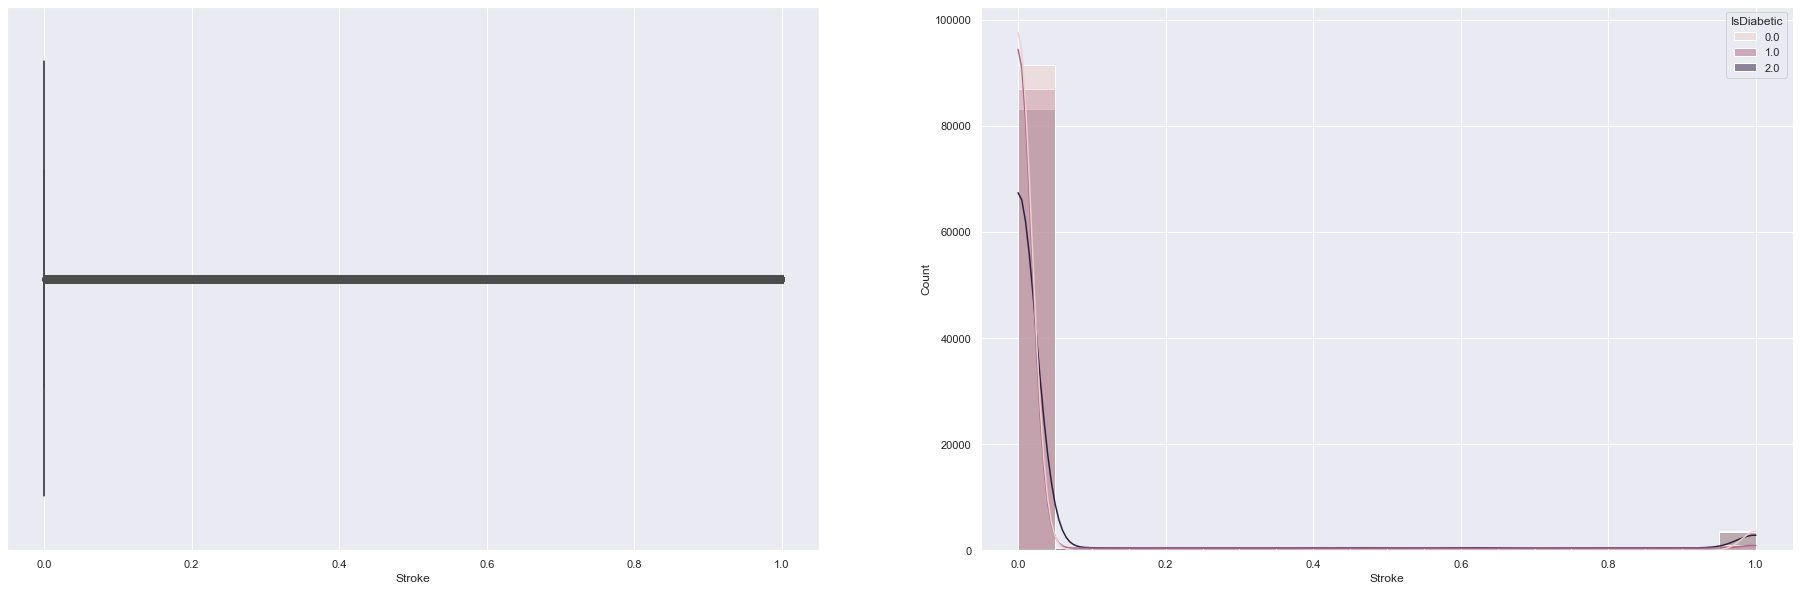

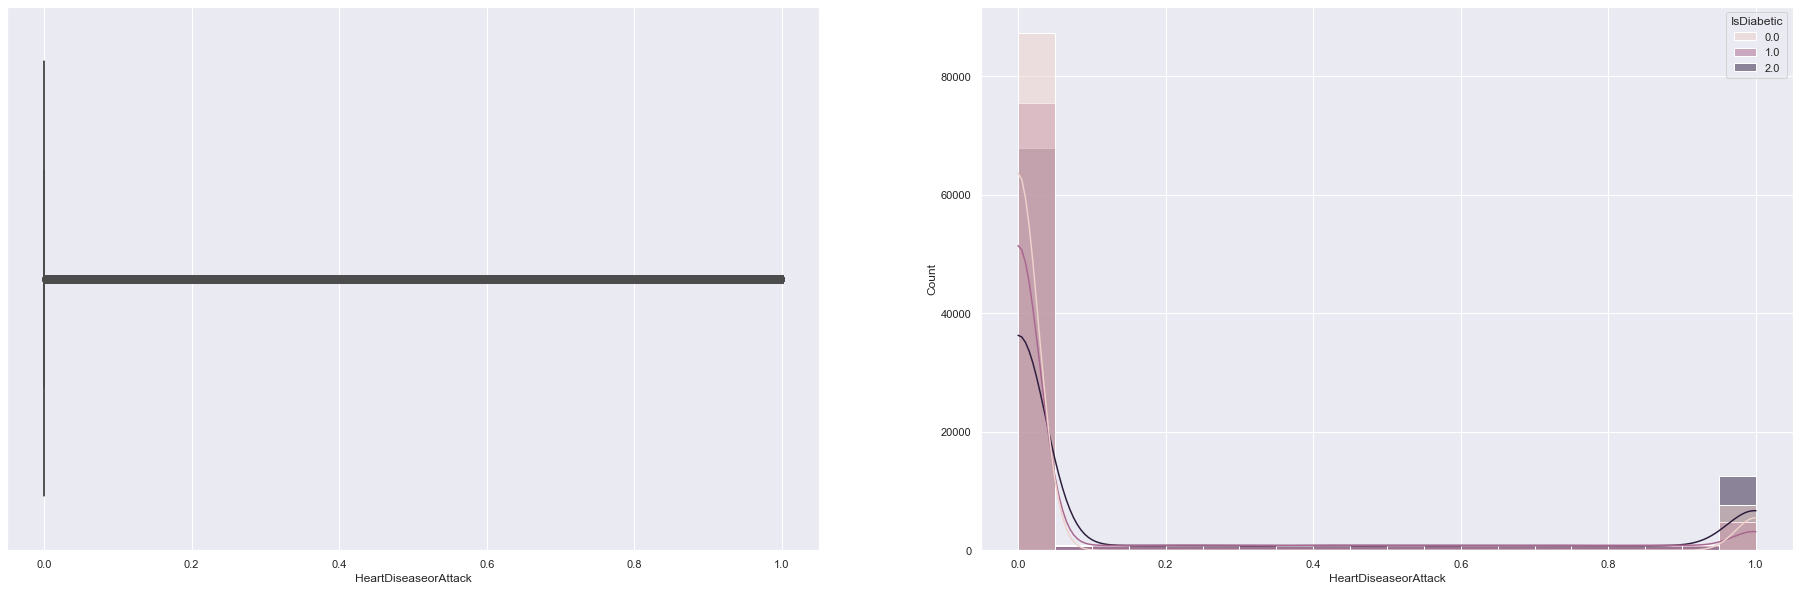

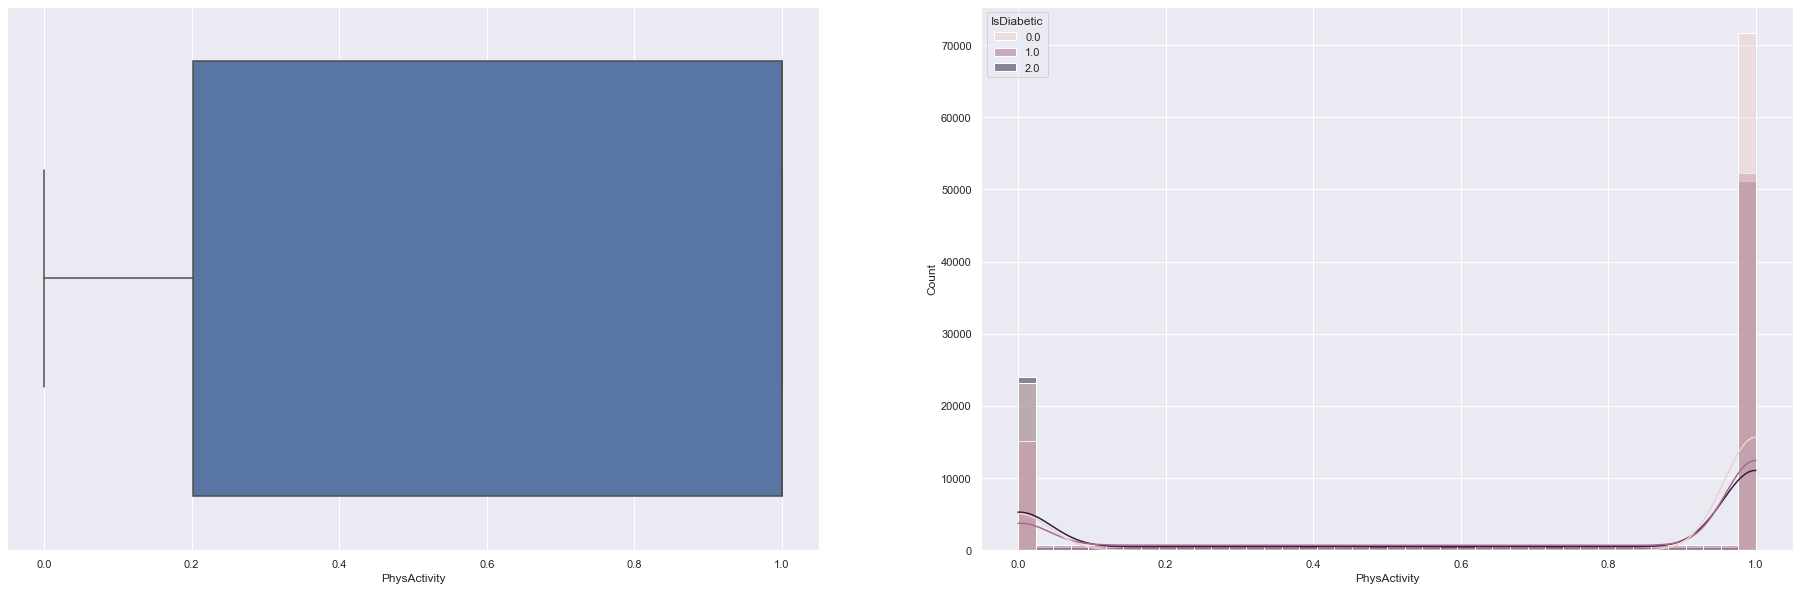

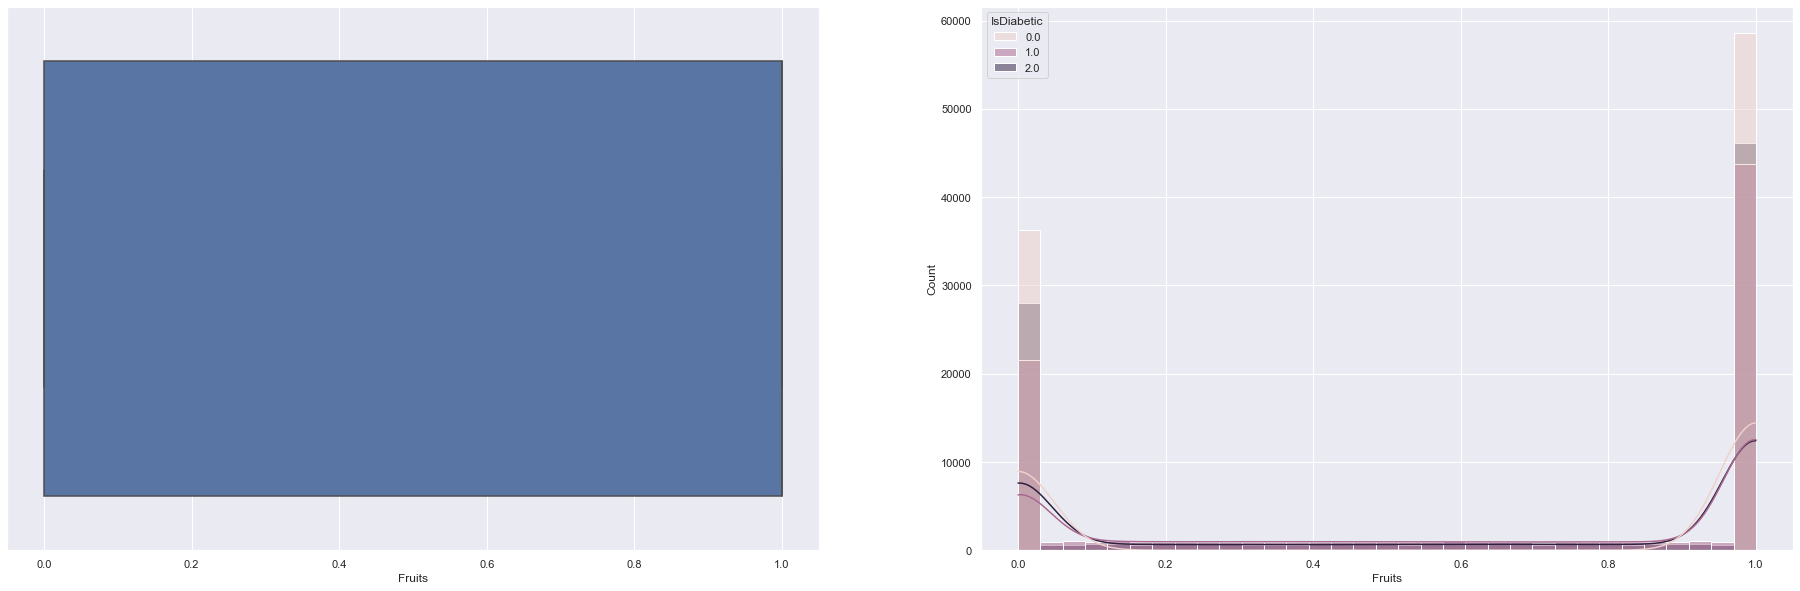

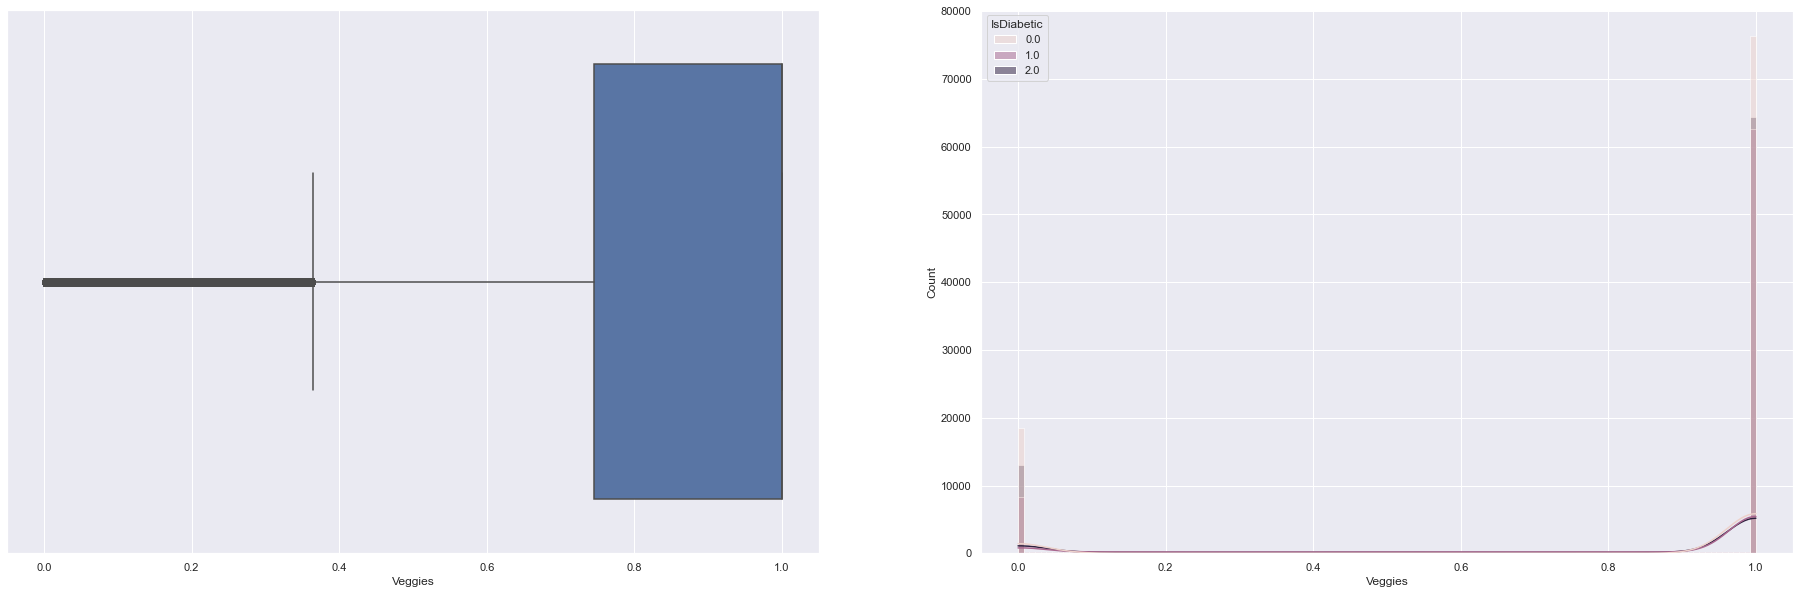

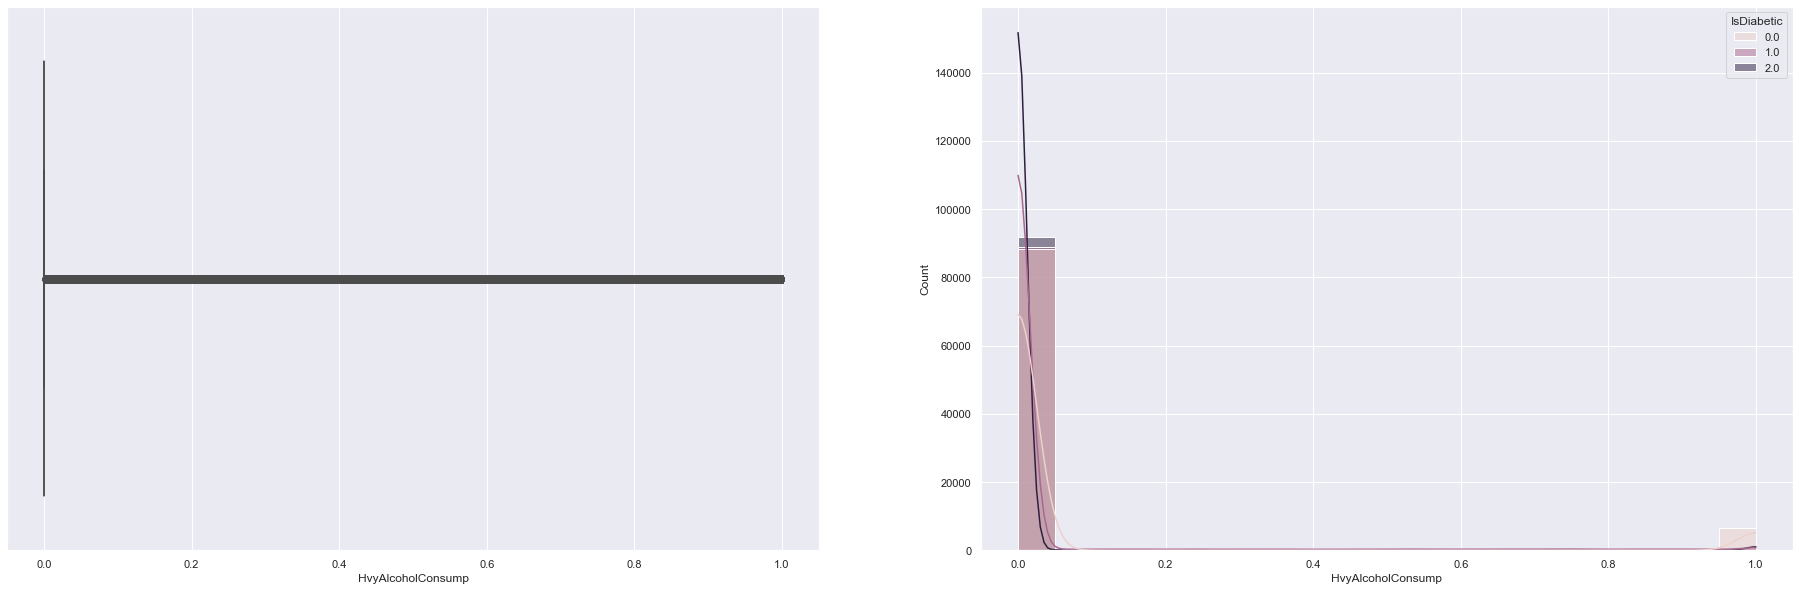

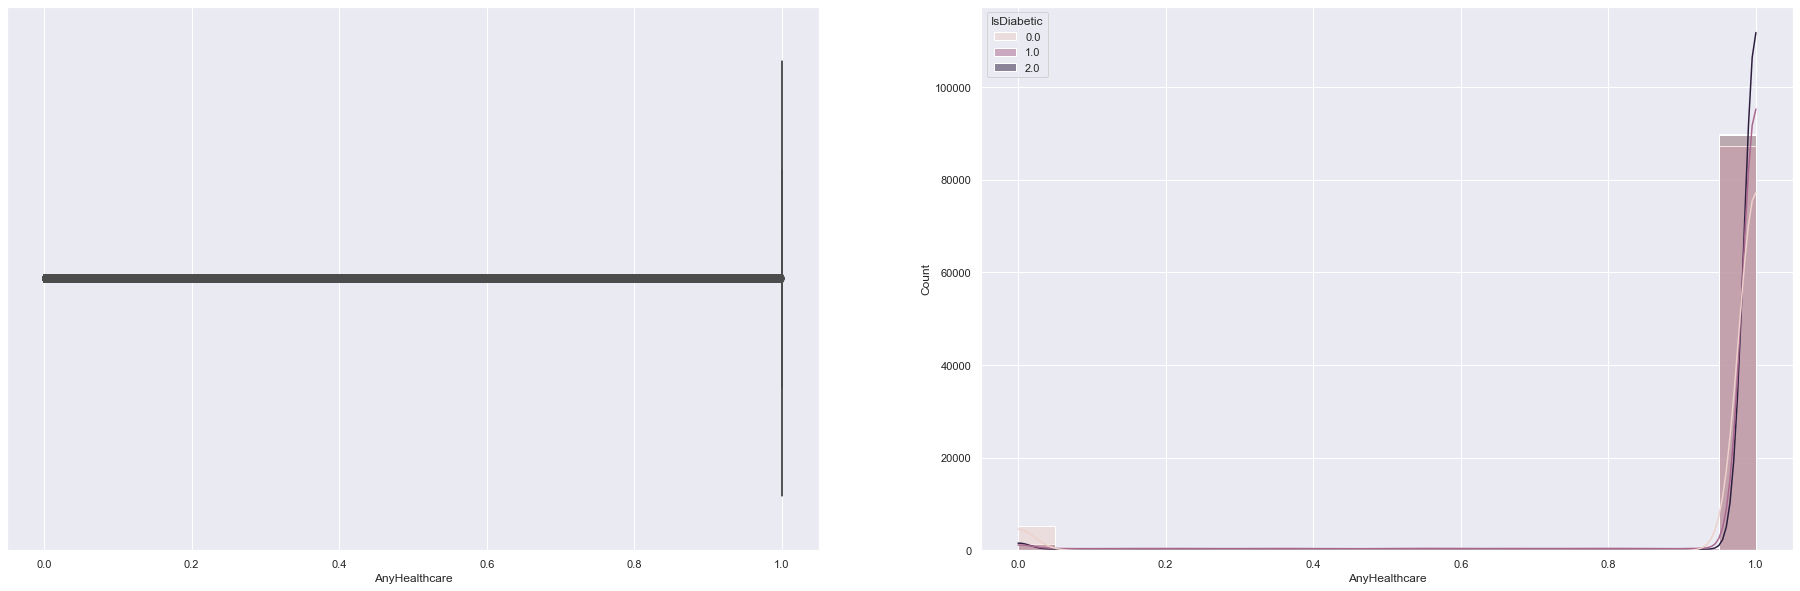

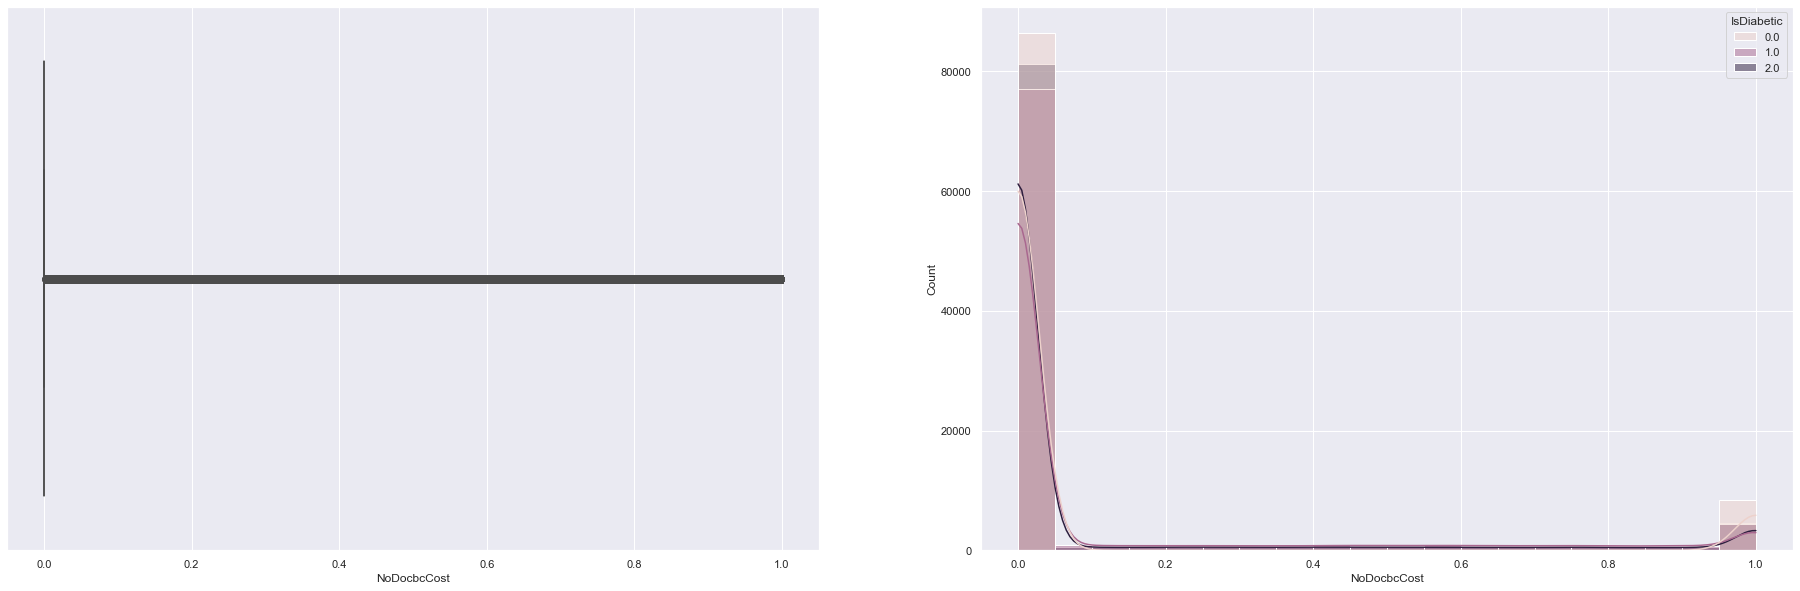

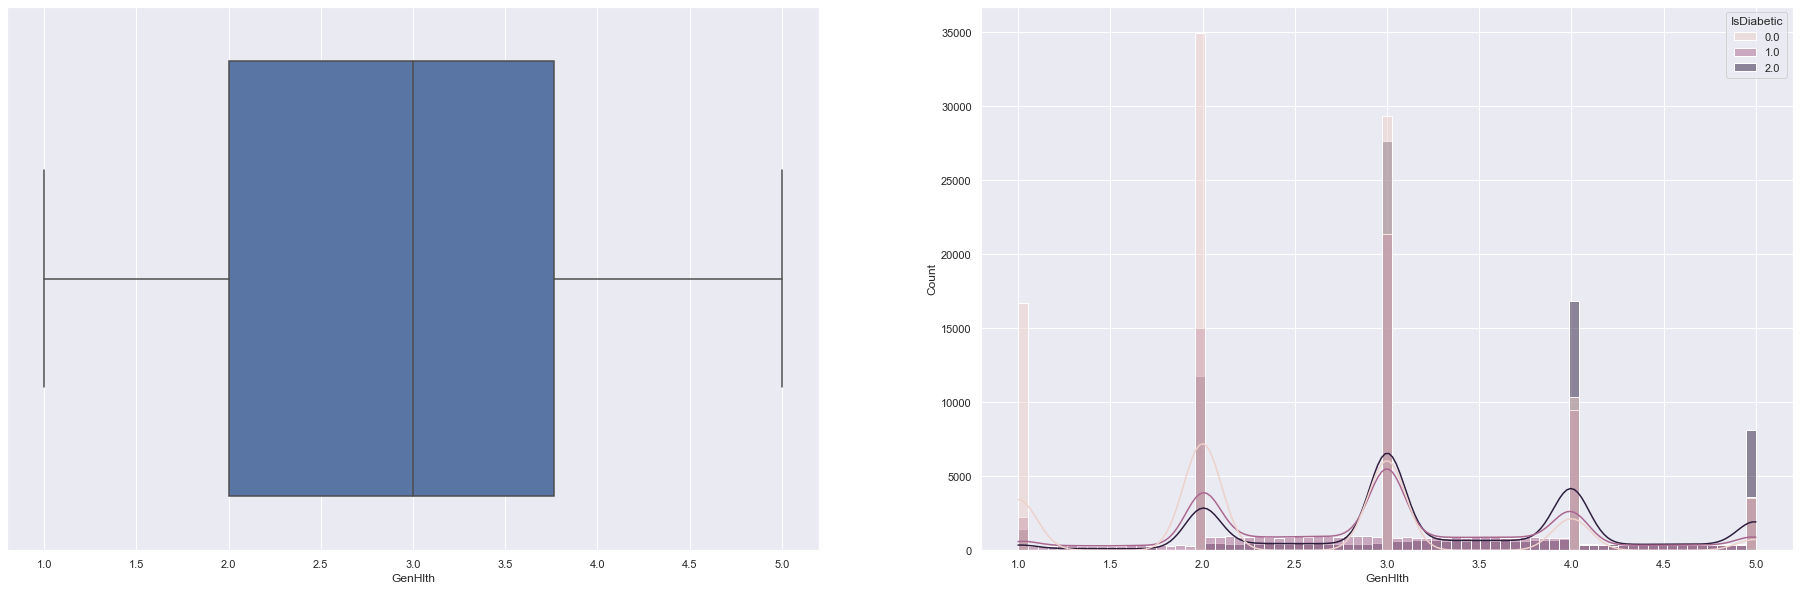

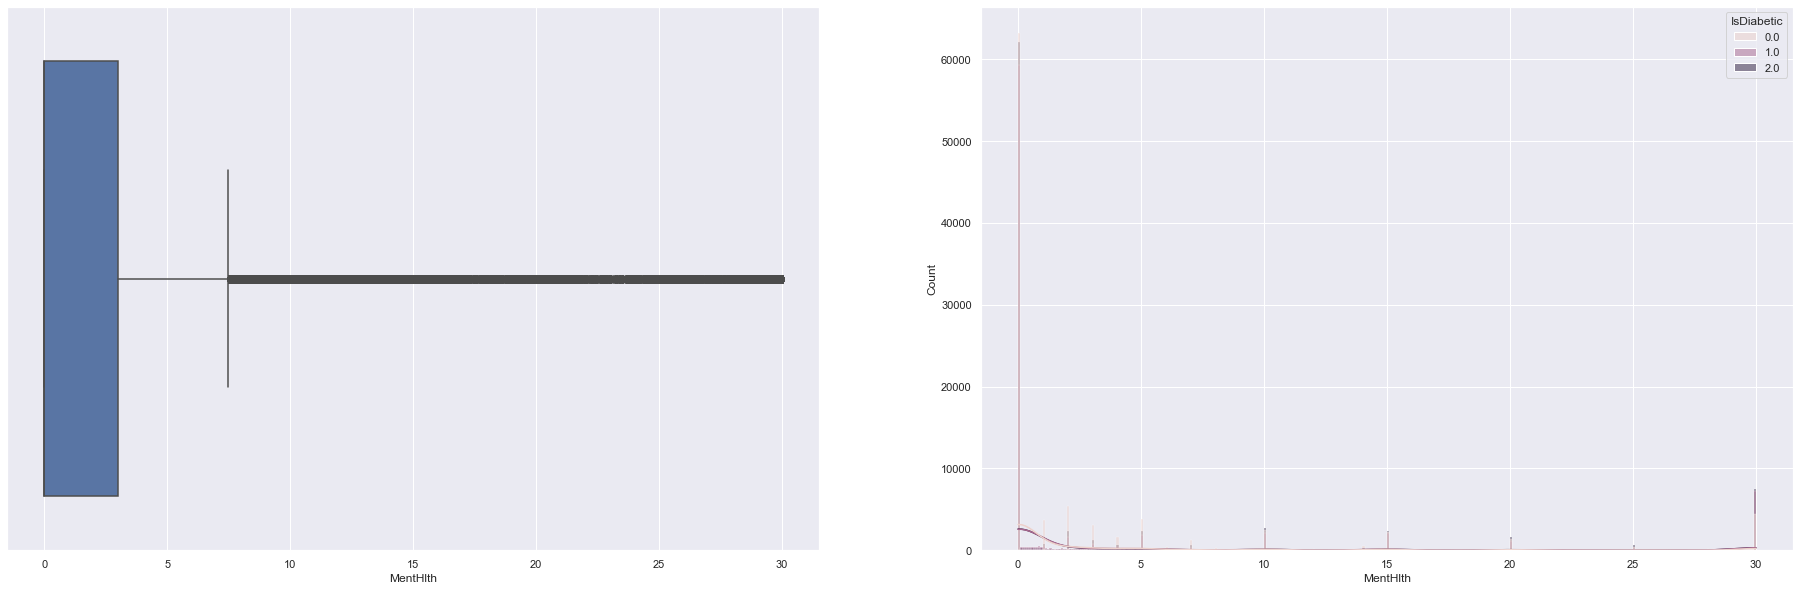

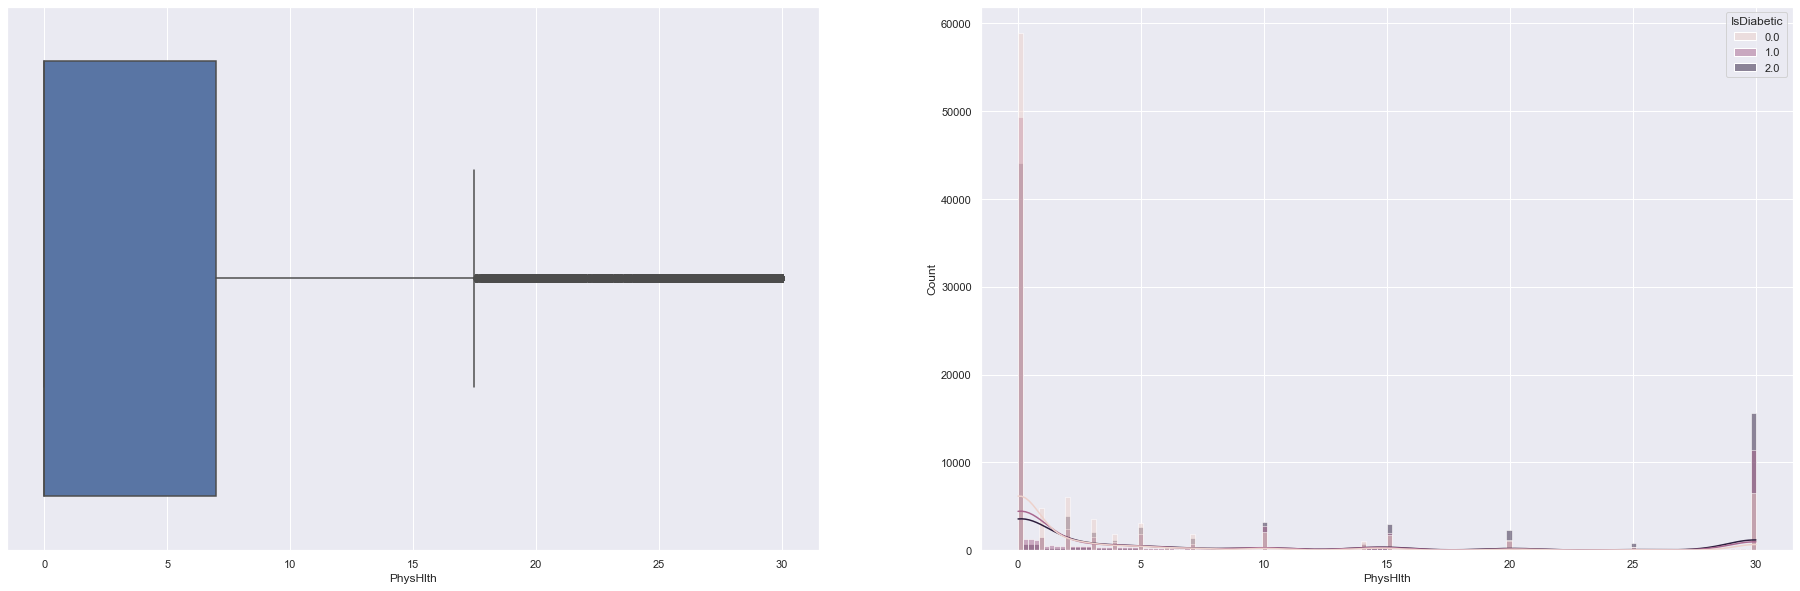

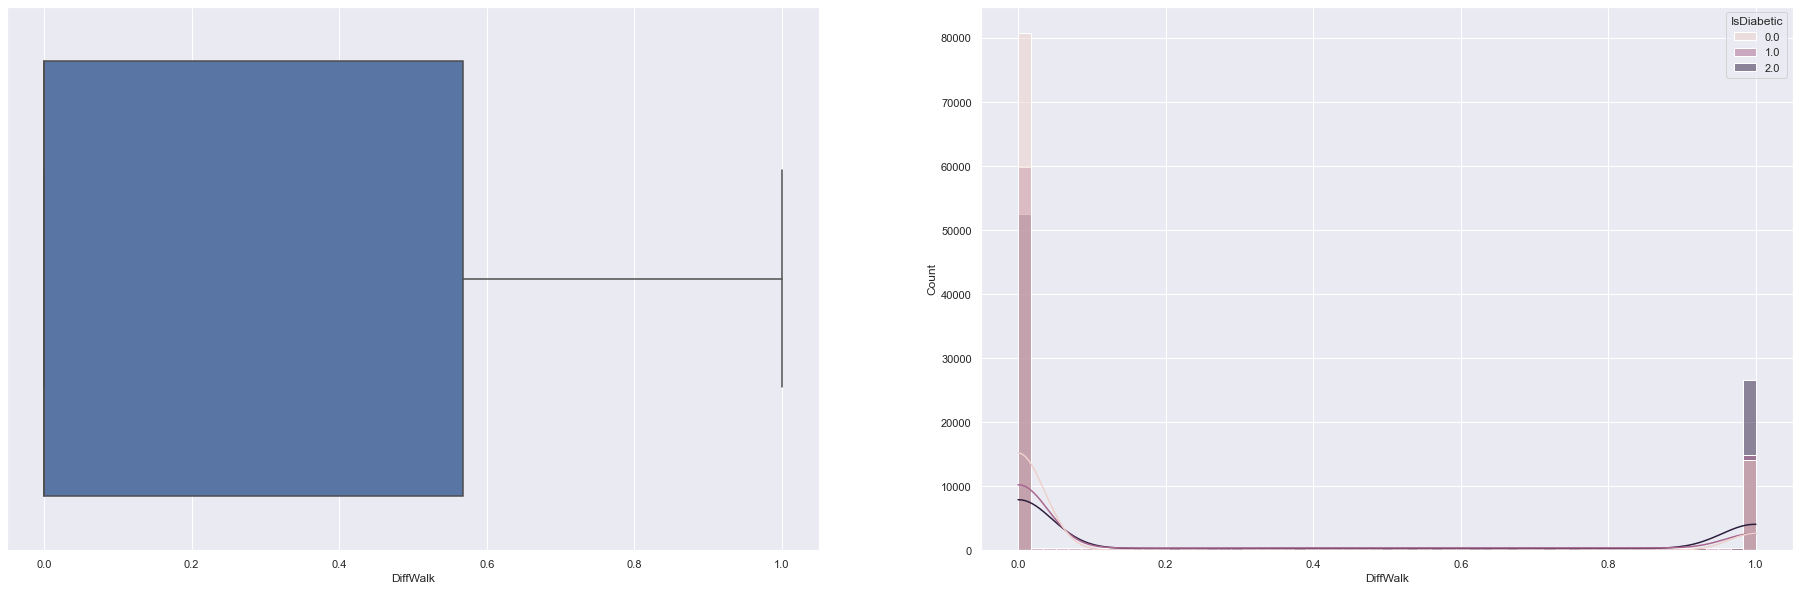

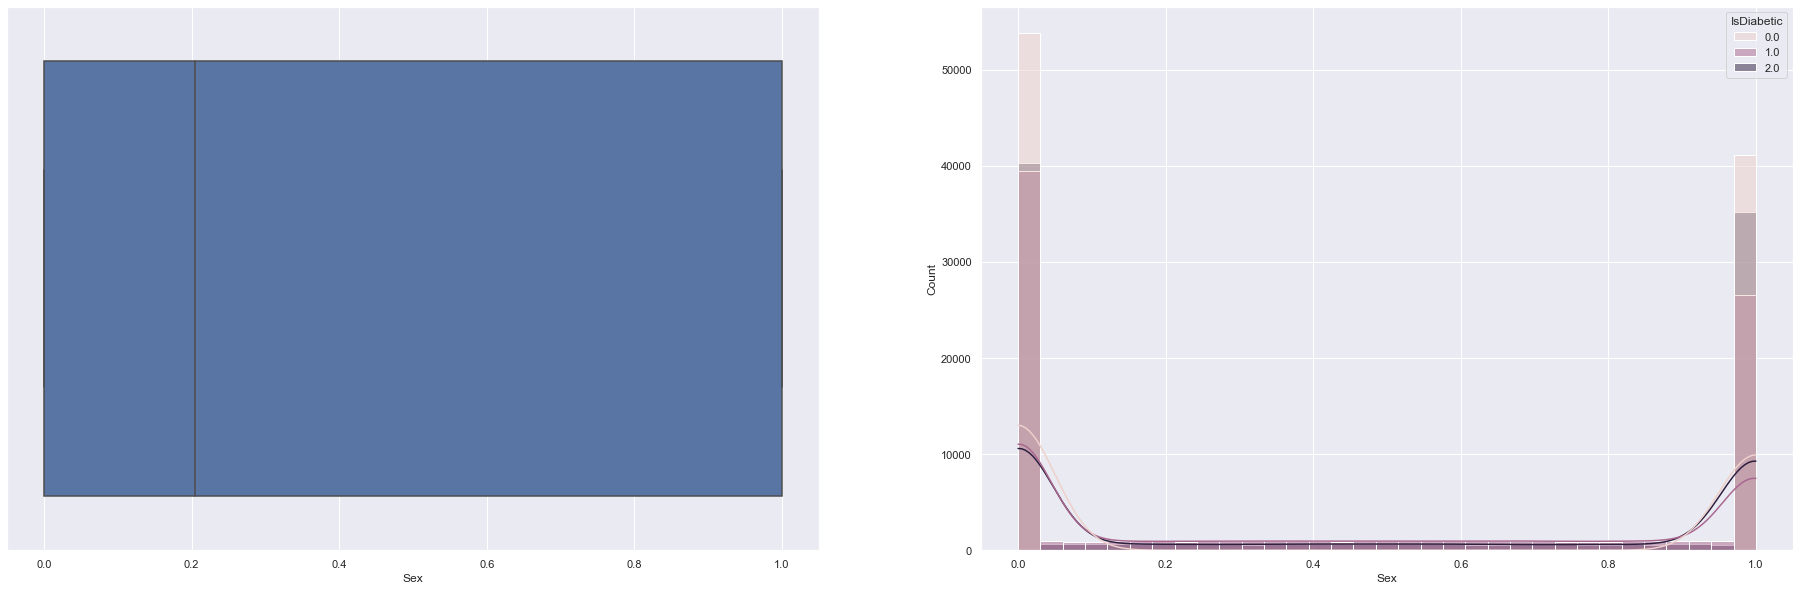

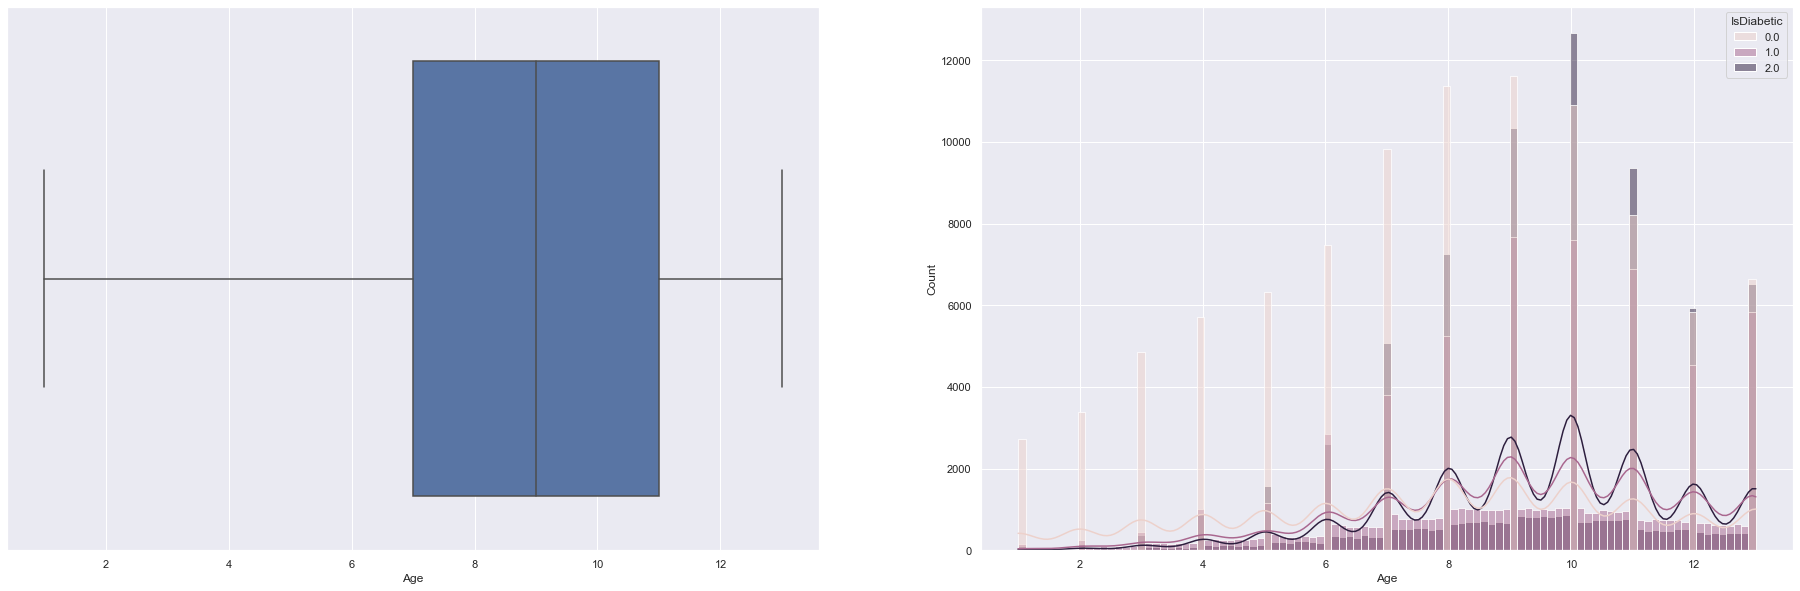

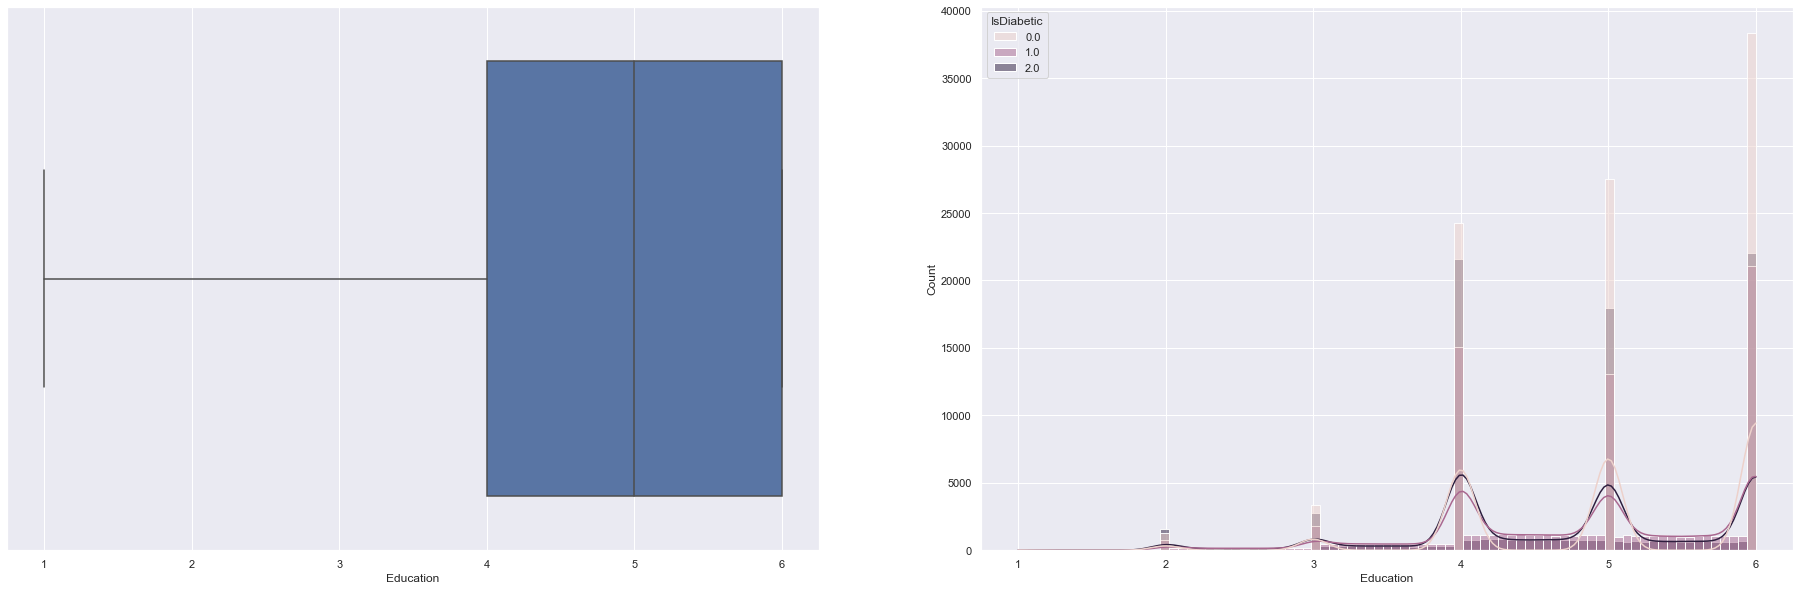

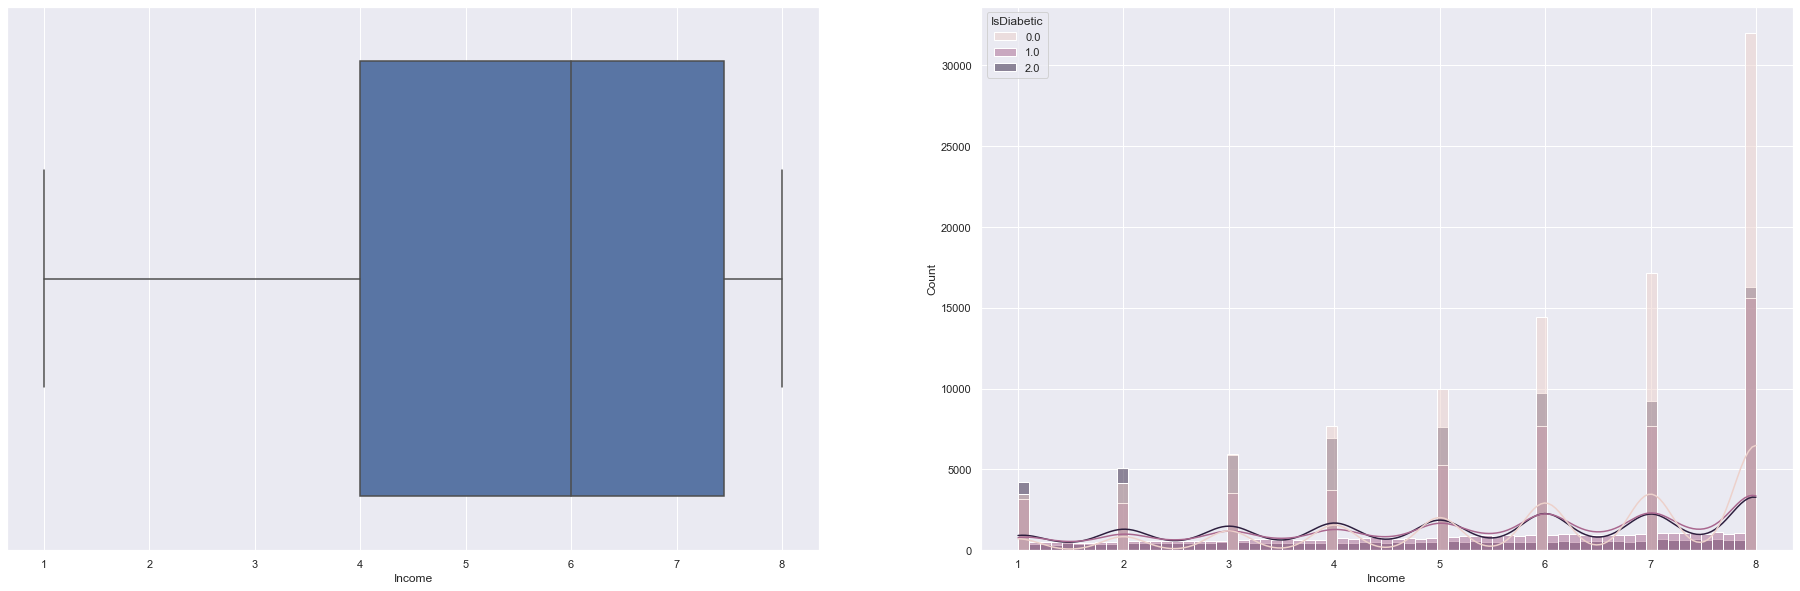

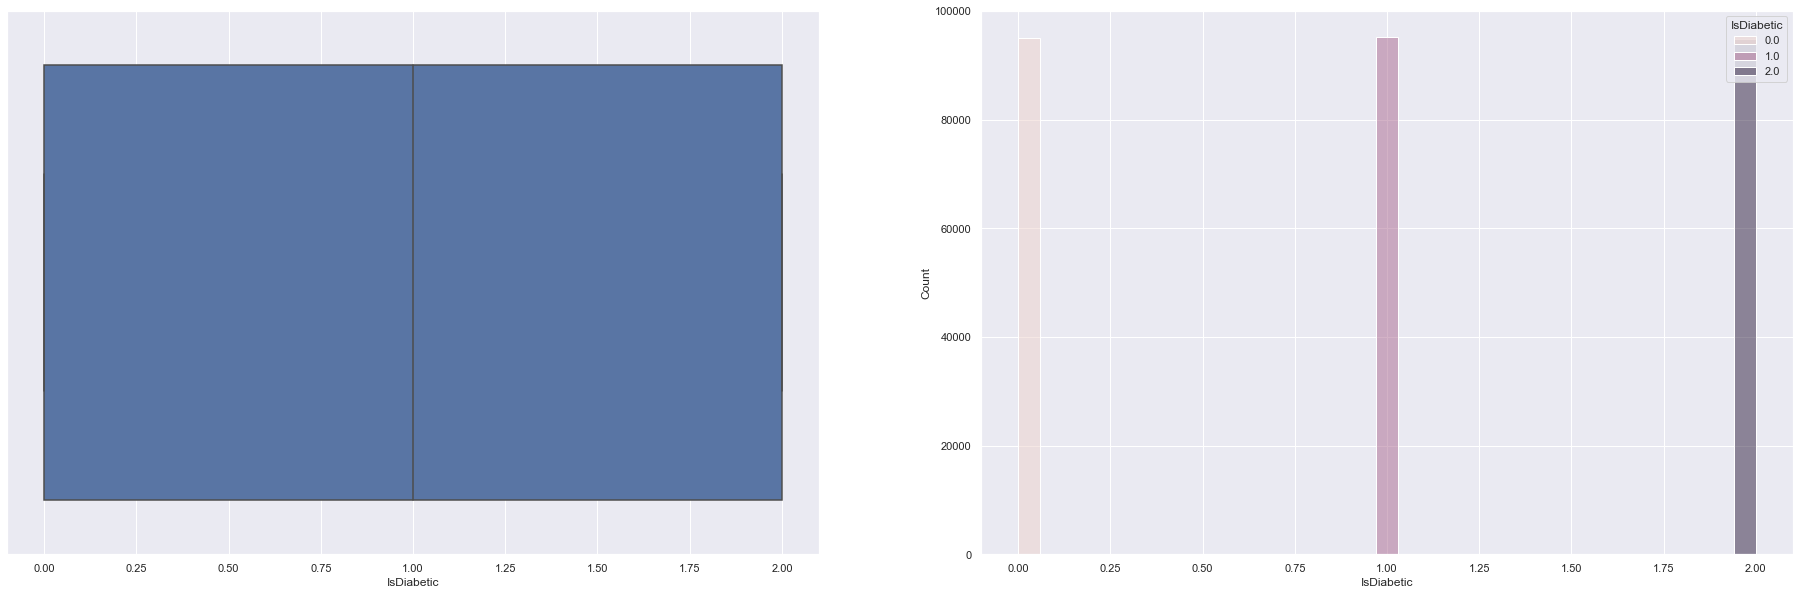

In [54]:
for i, feature in enumerate(data.columns):
    fig, ax = plt.subplots(1, 2, figsize = (32, 10))

    sns.boxplot(x=feature, ax = ax[0], hue="IsDiabetic", data=test_data)
    sns.histplot(x=feature, ax = ax[1], hue="IsDiabetic", kde=True, data=test_data)

    plt.show()

## Step 5. Feature importance

One Last thing before moving to summary and moving on to modeling I want to look at the feature importance.

This time im not actualy sure what the model is going to show so it will be a suprise.

> For feature importance the method we just train a model and see its views on the data

> Here we will try 3 different models and so our results could be very different based on the model

> why could it be different you ask? Well its because each model trains in its own way with a different algorithm.
 And since the algo's are different then the result can also be different.

Steps Are as Before

### 1. Setup Data

In [55]:
X = data.drop(["IsDiabetic"], axis=1)
y = data["IsDiabetic"]

X_train, x_, y_train, _ = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_ = scaler.transform(x_)

### 2. Training

#### Method 1. From Coefficients

In [56]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_[0]
})

importances = importances.sort_values(by='Importance', ascending=False, key=abs)

fig = px.bar(importances, x="Attribute", y="Importance", text_auto=True)
fig.update_layout(barmode='relative', title_text="Feature importances obtained from coefficients")
fig.show()

From the Above We can see not too much has changed from the file 2 coefff except this time its all inverted kinda. Interestingly the ai doesnt care much at all for HeartDisease, Mental Hlth, Fruites, Education and PhysActivity.

Next Up let me try with a tree model

#### Method 2. Importance From Trees

In [57]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

fig = px.bar(importances, x="Attribute", y="Importance", text_auto=True)
fig.update_layout(barmode='relative', title_text='Feature importances obtained from Trees')
fig.show()

Again Like last times tree check there is a huge difference from the coeff except here whats even more interesting is that genhlth has gon to 5th place! But still rest seems similar apart from a few. BBut still a shockking result.

#### Method 3. PCA

And as per last time the data can not be gotten directly so i will do a few extra steps, but unlike last time other than the graphs I wont be showing much.

In [58]:
pca = PCA().fit(X_train_scaled)

fig = px.line(y=pca.explained_variance_ratio_.cumsum(), title='Cumulative explained variance by number of principal components')
fig.show()

In [59]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

fig = px.bar(pc1_loadings, x="Attribute", y="CorrelationWithPC1", text_auto=True)
fig.update_layout(barmode='relative', title_text='PCA loading scores (first principal component)')
fig.show()

This one is both similar and not similar to the coeff starting with this one seems a lot like the ones from file 2. But otherwise Im pretty impressed with the results. The above should prove that different models think differently and hence give different results.

And so now we are Ready to start modeling


And just before starting modeling I will also like before removing the 3 fields for the same reasons given last time.

## Step 7. Removing Unwanted Fields

In [60]:
def remove_unwanted_fields(dataframe):
    return dataframe.drop(['AnyHealthcare', 'NoDocbcCost', 'CholCheck'], axis=1)

data = remove_unwanted_fields(data)

In [61]:
data.shape

(570165, 19)

## Step 7. Modelling
Again Here I will test all possible models bfore deciding on a final model to then do fine-tuning then export.

Plan for modeling
1. Train All possible models
2. Evaluate the models and find the best
3. Get the Best And Create Final Model
5. On the final model check feature importance (this part is just because im curios)
6. Export the model with joblib

*During Phase 1 and 2 I will use a very limited amount of data of around 70000 rows*

And with that lets start coding!

Here Unlike Last time I wont be doing fine-tuning because if i do it. The training will take toooooo long as I have a but ton of data.

#### Setting up the data

In [62]:
train_amount = 28000
type2_diabetic = data[data["IsDiabetic"] == 2].copy()
is_diabetic = data[data["IsDiabetic"] == 1].copy()
not_diabetic = data[data["IsDiabetic"] == 0].copy()

train_data = pd.concat(
	[
		type2_diabetic[0:train_amount],
		is_diabetic[0:train_amount],
		not_diabetic[0:train_amount]
	],
	ignore_index=True
)

X, y =  train_data.drop(['IsDiabetic'], axis=1), train_data.IsDiabetic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

pca = PCA(n_components = 18)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Starting to Model

#### Step1. Training all possible Models

***Do note if you are running this. It took me around 18 min for it to run***

In [63]:

trainees = [
    { "name": "Logistic Regression", "model": LogisticRegression(random_state=42) },
    { "name": "Random Forest", "model": RandomForestClassifier(random_state=42) },
    { "name": "LightGBM", "model": LGBMClassifier(is_unbalance = False, random_state=42) },
    { "name": "Support Vector Machines", "model": SVC(random_state=42) },
    { "name": "XGBoost", "model": XGBClassifier(random_state=42) },
    { "name": "Gaussian Naive Bayes", "model": GaussianNB() },
    { "name": "Bernoulli Naive Bayes", "model": BernoulliNB() },
    { "name": "KNN", "model": KNeighborsClassifier(n_neighbors=3) },
    { "name": "Decision Tree", "model": DecisionTreeClassifier(random_state=42) },
    { "name": "Bagging Classifier", "model": BaggingClassifier(base_estimator=RandomForestClassifier(), random_state=42) },
]

for trainee_data in trainees:
    trainee_data["model"].fit(X_train, y_train)
    print(f"mode {trainee_data['name']} finished training")


mode Logistic Regression finished training
mode Random Forest finished training
mode LightGBM finished training
mode Support Vector Machines finished training
mode XGBoost finished training
mode Gaussian Naive Bayes finished training
mode Bernoulli Naive Bayes finished training
mode KNN finished training
mode Decision Tree finished training
mode Bagging Classifier finished training


#### Step 2. Evaluating the Models

In [64]:
accuracy   = pd.DataFrame(columns=["name", "accuracy"])
matrix = []
precision = pd.DataFrame(columns=["name", "precision"])
true_positive = pd.DataFrame(columns=["name", "true_positive_rate"])
specificity = pd.DataFrame(columns=["name", "specificity"])
f1_score_ = pd.DataFrame(columns=["name", "score"])
pr_score = pd.DataFrame(columns=["name", "score"])

In [65]:
for model_data in trainees:
    predictions = model_data['model'].predict(X_test)

    # 1. Accuracy
    model_acc = {"name": model_data["name"], "accuracy": accuracy_score(y_test, predictions)}
    accuracy = accuracy.append(model_acc, ignore_index=True)

    # 2. Precision
    model_pre = {"name": model_data["name"], "precision": precision_score(y_test, predictions, average='micro')}
    precision = precision.append(model_pre, ignore_index=True)
    
    # 3. Recall/Sensitivity/True Positive Rate
    model_tpr = {"name": model_data["name"], "true_positive_rate": recall_score(y_test, predictions, average='micro')}
    true_positive = true_positive.append(model_tpr, ignore_index=True)
    
    # 4. F1 score
    model_f1_score = {"name": model_data["name"], "score": f1_score(y_test, predictions, average='micro')}
    f1_score_ = f1_score_.append(model_f1_score, ignore_index=True)

print(" Accuracy ".center(80, "="))
print(accuracy.sort_values(by="accuracy", ascending=False))
print()
print(" Precision ".center(80, "="))
print(precision.sort_values(by="precision", ascending=False))
print()
print(" True Positive Rate ".center(80, "="))
print(true_positive.sort_values(by="true_positive_rate", ascending=False))
print()
print(" F1 Score ".center(80, "="))
print(f1_score_.sort_values(by="score", ascending=False))
print()

=================================== Accuracy ===================================
                      name  accuracy
1            Random Forest  0.760381
9       Bagging Classifier  0.757048
3  Support Vector Machines  0.731762
4                  XGBoost   0.72981
2                 LightGBM  0.714333
7                      KNN  0.695476
8            Decision Tree  0.621048
5     Gaussian Naive Bayes     0.539
0      Logistic Regression  0.530571
6    Bernoulli Naive Bayes  0.491619

================================== Precision ===================================
                      name precision
1            Random Forest  0.760381
9       Bagging Classifier  0.757048
3  Support Vector Machines  0.731762
4                  XGBoost   0.72981
2                 LightGBM  0.714333
7                      KNN  0.695476
8            Decision Tree  0.621048
5     Gaussian Naive Bayes     0.539
0      Logistic Regression  0.530571
6    Bernoulli Naive Bayes  0.491619

======================

From the Above its obvious that both the bagging classifier and random forest classifier are the best! In fact the bagging classifier only beats the random forest classifier by .000905 is the best!! So I will be using the random forest classifier as I am more comfortable with that and the also the output size will be smaller compared to the bagging classifier. So that will be the final model that I wil use in my project. I already am very familiar with this model but still Ive never know how it exactly works and im going to do just that.

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

*Taken from the sklearn site*

Interesting! So that means this is very similar to the bagging classifier. Great!!

## Step 8. Exporting Model

So as stated in the modelling section I wont be Fine tunning and Since RandomForrest was showing the Best therefore I will create a final random forest model, train it and export it. Also Before exporting I will also be looking at the Feature Importance.

#### 8.1 Creating the Model

In [66]:
# final model
X, y =  data.drop(['IsDiabetic'], axis=1), data.IsDiabetic
model_2 = RandomForestClassifier(random_state=42)
model_2.fit(X, y)

RandomForestClassifier(random_state=42)

### 8.2 Feature Importance

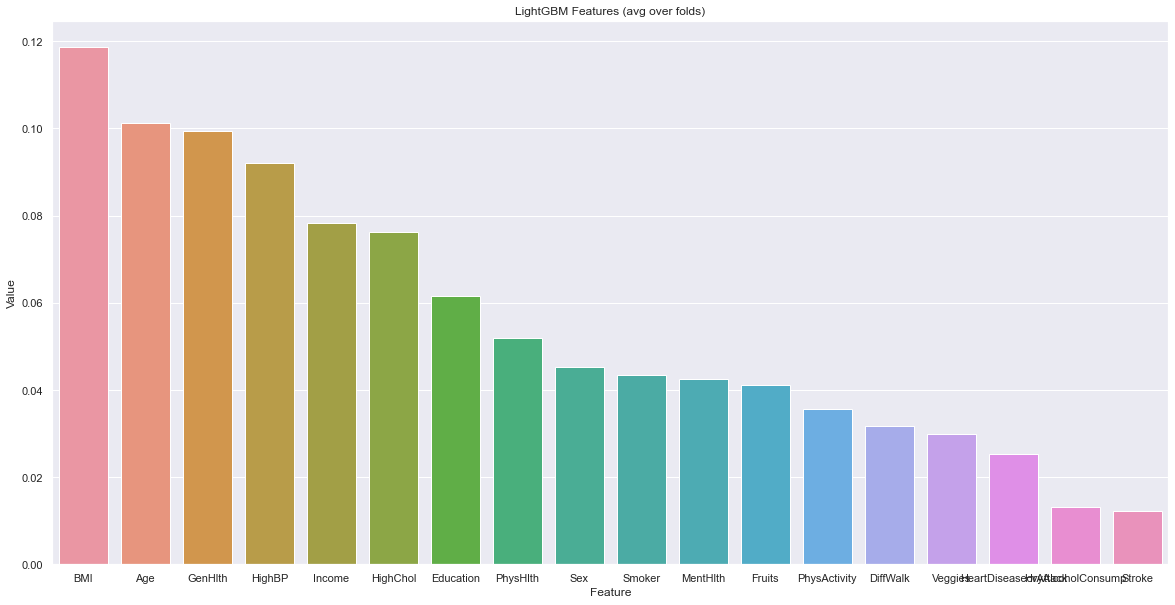

In [67]:
feature_imp = pd.DataFrame(sorted(zip(model_2.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Feature", y="Value", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.show()

In [68]:
fig = px.bar(feature_imp, x="Feature", y="Value", text_auto=True)
fig.update_layout(barmode='relative', title_text='RandomForestClassifier Features (avg over folds)')
fig.show()

Honestly Im impressed that the model cares about age and bmi too.

### 8.3 Exporting the Model

In [69]:
joblib.dump(model_2, './kaggle/output/model_2.sav')

['./kaggle/output/model_2.sav']

So now im finaly Done Witht the Models. Im soo happy. I hope you like this. Do tell if there is a better way for me to do this model building but otherwise thank you. And that is the Models Done!!!!

..................Well actually no.
(Ugh is this model ever going to end!!)

# Compression
So In my last commit you know i finished my model 2 and finished my api too but the problem arose when trying to upload the whole project on github. My Model Files where toooo big and so now here i am trying to compress both my model_1 and model_2. Still The main one I want to compress is model_2 but i will also see if I can compress model_1.

For this Section I will be using a lot of help from this [blog](https://mljar.com/blog/random-forest-memory/).

And as tradition in this file lets begin with model_1

## Model 1

In [70]:
model_1

LGBMClassifier(is_unbalance=False, random_state=42)

In [72]:
joblib.dump(model_1, './kaggle/output/model_1_compressed.sav', compress=3)

['./kaggle/output/model_1_compressed.sav']

Now on Checking the Result the new compressed model is 137 kilobytes whereas the old model is 343 kilobytes! Thats around 61% improvement compared to the old model. Now since the lightgbm model was already small to begin with im realy sattisfied with this much.

## Model 2

Next Up the Model_2.

In [86]:
joblib.dump(model_2, './kaggle/output/model_2_compressed.sav', compress=5)

['./kaggle/output/model_2_compressed.sav']

Lets goooooo! Our model size has now gone from 1.2 gb to just 195mb which is a very good improvement. So now I believe this is a  good enough improvement to save to github.

So this is finally Done And So thank you!